# НИР

In [1]:
%pip install torch pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 69.5 MB/s eta 0:00:00


## Импорт библиотек

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import zipfile
import urllib.request
import shutil
import matplotlib.pyplot as plt
import math
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, classification_report, confusion_matrix
)
import shap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Переменные среды

In [ ]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)


ZIP_URL = "https://files.ffiec.cfpb.gov/static-data/snapshot/2024/2024_public_lar_csv.zip"
ZIP_PATH = DATA_DIR / "2024_public_lar_csv.zip"
RAW_CSV_PATH = DATA_DIR / "2024_public_lar_csv.csv"
#CLEAN_CSV_PATH = DATA_DIR / "2024_public_lar_csv_clean.csv"
CLEAN_CSV_PATH = DATA_DIR / "/content/drive/MyDrive/2024_public_lar_csv_clean.csv"

SENSITIVE = [
    # sensitive (protected) directly
    "derived_ethnicity",
    "derived_race",
    "derived_sex",
    "applicant_race_1",
    "applicant_sex",
    "applicant_ethnicity_1",
    "co_applicant_race_1",
    "co_applicant_sex",
    "co_applicant_ethnicity_1",

    # age-related (protected)
    "applicant_age",
    "co_applicant_age",
    "applicant_age_above_62",
    "co_applicant_age_above_62",

    # strong demographic proxy (keep for audit)
    "tract_minority_population_percent",

    # geography / market proxy (usually audit-only for "clean" fairness model)
    "derived_msa_md",
]

Y_COL = "action_taken"

SENSITIVE_COLS = [
    "derived_ethnicity",
    "derived_race",
    "derived_sex",
]

TEST_SIZE = 0.15
VAL_SIZE  = 0.15
RANDOM_STATE = 42
RARE_MIN_COUNT = 10

## Загрузка датасета

In [8]:
def download_file(url: str, dst: Path, chunk_size: int = 2**20) -> None:
    dst.parent.mkdir(parents=True, exist_ok=True)
    tmp = dst.with_suffix(dst.suffix + ".part")

    print(f"Downloading:\n  {url}\n-> {dst}")
    req = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
    with urllib.request.urlopen(req) as r, open(tmp, "wb") as f:
        total = r.headers.get("Content-Length")
        total = int(total) if total is not None else 0
        downloaded = 0

        while True:
            chunk = r.read(chunk_size)
            if not chunk:
                break
            f.write(chunk)
            downloaded += len(chunk)
            if total:
                print(f"\r  {downloaded/total:6.1%} ({downloaded/1024/1024:.1f} MB)", end="")

    print("\nDownload finished.")
    tmp.replace(dst)

if not RAW_CSV_PATH.exists():
    if not ZIP_PATH.exists():
        download_file(ZIP_URL, ZIP_PATH)

    print(f"Extracting CSV from:\n  {ZIP_PATH}\n-> {DATA_DIR}")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        csv_members = [n for n in z.namelist() if n.lower().endswith(".csv")]
        if not csv_members:
            raise RuntimeError("ZIP does not contain a CSV file.")
        # Usually there is exactly one CSV:
        member = csv_members[0]
        z.extract(member, DATA_DIR)

        extracted_path = DATA_DIR / member
        # If the CSV is inside a folder or has a different name, normalize it:
        if extracted_path != RAW_CSV_PATH:
            extracted_path.replace(RAW_CSV_PATH)

    print(f"Raw CSV ready: {RAW_CSV_PATH}")
else:
    print(f"Raw CSV already exists: {RAW_CSV_PATH}")

Downloading:
  https://files.ffiec.cfpb.gov/static-data/snapshot/2024/2024_public_lar_csv.zip
-> data/2024_public_lar_csv.zip
  100.0% (633.5 MB)
Download finished.
Extracting CSV from:
  data/2024_public_lar_csv.zip
-> data
Raw CSV ready: data/2024_public_lar_csv.csv


## Инфо по бд

In [9]:
df = pd.read_csv(RAW_CSV_PATH, low_memory=False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12229298 entries, 0 to 12229297
Data columns (total 99 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   activity_year                             int64  
 1   lei                                       object 
 2   derived_msa_md                            int64  
 3   state_code                                object 
 4   county_code                               float64
 5   census_tract                              object 
 6   conforming_loan_limit                     object 
 7   derived_loan_product_type                 object 
 8   derived_dwelling_category                 object 
 9   derived_ethnicity                         object 
 10  derived_race                              object 
 11  derived_sex                               object 
 12  action_taken                              int64  
 13  purchaser_type                            int64  
 14  

In [8]:
tmp = df.copy()
tmp = tmp[tmp["loan_purpose"] == 1]
tmp = tmp[tmp["action_taken"].isin([1,3])]
print(tmp["action_taken"].value_counts(dropna=False))
print("loan_amount missing by action_taken:\n", tmp.groupby("action_taken")["loan_amount"].apply(lambda s: s.isna().mean()))
print("income missing by action_taken:\n", tmp.groupby("action_taken")["income"].apply(lambda s: s.isna().mean()))


action_taken
1    3517224
3     621707
Name: count, dtype: int64
loan_amount missing by action_taken:
 action_taken
1    0.0
3    0.0
Name: loan_amount, dtype: float64
income missing by action_taken:
 action_taken
1    0.044611
3    0.042716
Name: income, dtype: float64


## Чистка датасета

In [11]:
def TODROP(df: pd.DataFrame) -> pd.DataFrame:
    """
    1) Фильтруем строки:
       - loan_purpose == 1
       - action_taken in {1, 3}
       - loan_amount NOT NaN
       - income NOT NaN
    2) Превращаем action_taken в бинарный таргет:
       - 1 -> 1
       - 3 -> 0
    3) Дропаем:
       - все denial_reason_* (утечка)
       - константы (loan_purpose, activity_year, multifamily_affordable_units)
       - все колонки, которые ОКАНЧИВАЮТСЯ на _2/_3/_4/_5
    4) Фильтруем строки по "валидности" sensitive полей:
       - applicant_sex NOT IN {3,4}
       - co_applicant_sex NOT IN {3,4}
       - applicant_race_1 NOT IN {6,7}
       - co_applicant_race_1 NOT IN {6,7}
       - applicant_ethnicity_1 NOT IN {3,4}
       - co_applicant_ethnicity_1 NOT IN {3,4}
       - applicant_age != "8888"
       - co_applicant_age != "8888"
    5) Дропаем колонки: loan_type, lien_status, construction_method, total_units
    """
    out = df.copy()

    def _log(tag, before_len):
        after_len = len(out)
        dropped = before_len - after_len
        print(f"[TODROP] {tag}: {before_len:,} -> {after_len:,}  (dropped {dropped:,}, {dropped/before_len*100:.3f}%)")

    b = len(out)

    # row filters
    out = out.loc[out["loan_purpose"] == 1].copy()
    _log("loan_purpose==1", b)
    b = len(out)
    out = out.loc[out["action_taken"].isin([1, 3])].copy()
    _log("action_taken in {1,3}", b)
    b = len(out)
    out = out.loc[out["loan_amount"].notna() & out["income"].notna()].copy()
    _log("loan_amount & income notna", b)

    # y: 1 if originated else 0 (denied)
    out["action_taken"] = (out["action_taken"] == 1).astype(np.int8)

    # ---- drop denial reasons ----
    drop_cols = [c for c in out.columns if c.startswith("denial_reason")]

    # ---- drop suffix _2/_3/_4/_5 ----
    drop_cols += [c for c in out.columns if re.search(r"_(2|3|4|5)$", c) is not None]

    # ---- drop known constants ----
    drop_cols += [c for c in ["loan_purpose", "activity_year", "multifamily_affordable_units"] if c in out.columns]

    # ---- drop requested columns ----
    drop_cols += [c for c in ["loan_type", "lien_status", "construction_method", "total_units", "purchaser_type", "initially_payable_to_institution", "manufactured_home_secured_property_type", "aus_1", "lei", "applicant_credit_score_type", "co_applicant_credit_score_type", "hoepa_status", "submission_of_application", "interest_rate", "rate_spread", "total_loan_costs", "total_points_and_fees", "origination_charges", "discount_points", "lender_credits", "prepayment_penalty_term", "intro_rate_period"] if c in out.columns]

    out = out.drop(columns=sorted(set(drop_cols)), errors="ignore")

    # =========================
    # Sensitive row filters
    # =========================
    def _filter_not_in(col, bad_vals, tag):
        nonlocal out
        if col in out.columns:
            b = len(out)
            s = pd.to_numeric(out[col], errors="coerce")
            out = out.loc[~s.isin(bad_vals)].copy()
            _log(tag, b)

    _filter_not_in("applicant_sex", [3, 4], "applicant_sex not in {3,4}")
    _filter_not_in("co_applicant_sex", [3, 4], "co_applicant_sex not in {3,4}")

    _filter_not_in("applicant_race_1", [6, 7], "applicant_race_1 not in {6,7}")
    _filter_not_in("co_applicant_race_1", [6, 7], "co_applicant_race_1 not in {6,7}")

    _filter_not_in("applicant_ethnicity_1", [3, 4], "applicant_ethnicity_1 not in {3,4}")
    _filter_not_in("co_applicant_ethnicity_1", [3, 4], "co_applicant_ethnicity_1 not in {3,4}")

    if "applicant_age" in out.columns:
        b = len(out)
        out = out.loc[out["applicant_age"].astype("string") != "8888"].copy()
        _log("applicant_age != 8888", b)

    if "co_applicant_age" in out.columns:
        b = len(out)
        out = out.loc[out["co_applicant_age"].astype("string") != "8888"].copy()
        _log("co_applicant_age != 8888", b)

    print(f"[TODROP] FINAL: {len(out):,} rows")
    return out

# ===== usage =====
df = TODROP(df)
df.info()
print(df["action_taken"].value_counts())


[TODROP] loan_purpose==1: 12,229,298 -> 6,553,105  (dropped 5,676,193, 46.415%)
[TODROP] action_taken in {1,3}: 6,553,105 -> 4,138,931  (dropped 2,414,174, 36.840%)
[TODROP] loan_amount & income notna: 4,138,931 -> 3,955,466  (dropped 183,465, 4.433%)
[TODROP] applicant_sex not in {3,4}: 3,955,466 -> 3,752,412  (dropped 203,054, 5.134%)
[TODROP] co_applicant_sex not in {3,4}: 3,752,412 -> 3,719,075  (dropped 33,337, 0.888%)
[TODROP] applicant_race_1 not in {6,7}: 3,719,075 -> 3,341,472  (dropped 377,603, 10.153%)
[TODROP] co_applicant_race_1 not in {6,7}: 3,341,472 -> 3,294,555  (dropped 46,917, 1.404%)
[TODROP] applicant_ethnicity_1 not in {3,4}: 3,294,555 -> 3,184,117  (dropped 110,438, 3.352%)
[TODROP] co_applicant_ethnicity_1 not in {3,4}: 3,184,117 -> 3,166,410  (dropped 17,707, 0.556%)
[TODROP] applicant_age != 8888: 3,166,410 -> 3,165,832  (dropped 578, 0.018%)
[TODROP] co_applicant_age != 8888: 3,165,832 -> 3,165,130  (dropped 702, 0.022%)
[TODROP] FINAL: 3,165,130 rows
<class 

## Генерация фичей

In [12]:
def FEATENG(df: pd.DataFrame) -> pd.DataFrame:
    """
    1) Создаём has_coapplicant по правилу (0 если выполняется ХОТЯ БЫ ОДНО условие):
       - co_applicant_race_1 == 8
       - co_applicant_ethnicity_1 == 5
       - co_applicant_sex == 5
       - co_applicant_age == 9999
       - co_applicant_ethnicity_observed == 4
       - co_applicant_race_observed == 4
       - co_applicant_sex_observed == 4
       - co_applicant_credit_score_type == 10
       иначе has_coapplicant = 1

    2) nonamortizing_flag (единая фича из 4):
       - исходные: negative_amortization, interest_only_payment, balloon_payment, other_nonamortizing_features
       - коды: 1, 2, 1111
       - если все одинаковы -> оставить этот код
       - иначе взять доминирующий (mode)
       - если ничья -> приоритет 1 > 1111 > 2
       - затем дропнуть 4 исходные колонки

    3) Дропаем sensitive колонки (applicant + co_applicant):
       - applicant_race_1, applicant_sex, applicant_ethnicity_1
       - applicant_ethnicity_observed, applicant_race_observed, applicant_sex_observed
       - co_applicant_race_1, co_applicant_sex, co_applicant_ethnicity_1
       - co_applicant_ethnicity_observed, co_applicant_race_observed, co_applicant_sex_observed

    4) Преобразуем гео метки:
       - owner_occ_ratio = tract_owner_occupied_units / tract_one_to_four_family_homes
       - homes_per_capita = tract_one_to_four_family_homes / tract_population
       - tract_median_income_est = ffiec_msa_md_median_family_income * (tract_to_msa_income_percentage/100)
       - rating_income_tract = income / tract_median_income_est
       - затем дропаем изначальные

    """
    out = df.copy()

    # --- build has_coapplicant ---
    needed = [
        "co_applicant_race_1",
        "co_applicant_ethnicity_1",
        "co_applicant_sex",
        "co_applicant_age",
        "co_applicant_ethnicity_observed",
        "co_applicant_race_observed",
        "co_applicant_sex_observed",
    ]
    missing = [c for c in needed if c not in out.columns]
    if missing:
        raise KeyError(f"Не хватает колонок для has_coapplicant: {missing}")

    race = pd.to_numeric(out["co_applicant_race_1"], errors="coerce")
    eth1 = pd.to_numeric(out["co_applicant_ethnicity_1"], errors="coerce")
    sex = pd.to_numeric(out["co_applicant_sex"], errors="coerce")
    age = out["co_applicant_age"].astype("string").str.strip()
    eth_obs = pd.to_numeric(out["co_applicant_ethnicity_observed"], errors="coerce")
    race_obs = pd.to_numeric(out["co_applicant_race_observed"], errors="coerce")
    sex_obs = pd.to_numeric(out["co_applicant_sex_observed"], errors="coerce")

    no_coapp = (
        (race == 8) |
        (eth1 == 5) |
        (sex == 5) |
        (age == "9999") |
        (eth_obs == 4) |
        (race_obs == 4) |
        (sex_obs == 4)
    )

    out["has_coapplicant"] = (~no_coapp).astype(np.int8)

    # --- build special_loan_conditions (fast, vectorized) ---
    NONAMORT_COLS = [
        "negative_amortization",
        "interest_only_payment",
        "balloon_payment",
        "other_nonamortizing_features",
    ]
    EXTRA_COLS = ["reverse_mortgage", "open_end_line_of_credit"]
    ALL_COLS = NONAMORT_COLS + EXTRA_COLS

    if all(c in out.columns for c in ALL_COLS):
        # to numeric
        X = out[ALL_COLS].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=np.float64)

        has1 = (X == 1).any(axis=1)
        has2 = (X == 2).any(axis=1)

        # if any 1 -> 1; else if any 2 -> 2; else 1111
        out["special_loan_conditions"] = np.where(has1, 1, np.where(has2, 2, 1111)).astype(np.int64)

        # дропаем 4 исходные non-amortizing колонки (как раньше)
        out = out.drop(columns=ALL_COLS, errors="ignore")
    else:
        # если каких-то колонок нет — пропускаем
        pass

    # --- census feature engineering (ratios + tract income) ---
    eps = 1e-6

    geo_cols = [
        "tract_owner_occupied_units",
        "tract_one_to_four_family_homes",
        "tract_population",
        "ffiec_msa_md_median_family_income",
        "tract_to_msa_income_percentage",
    ]
    present_geo = [c for c in geo_cols if c in out.columns]

    if present_geo:
        # считаем "плохими" NaN/inf, а также 0 там, где 0 быть не должно (pop/homes/income)
        bad = pd.DataFrame(index=out.index)

        for c in present_geo:
            s = pd.to_numeric(out[c], errors="coerce").astype("float64").replace([np.inf, -np.inf], np.nan)
            if c in ["tract_owner_occupied_units", "tract_one_to_four_family_homes", "tract_population", "ffiec_msa_md_median_family_income"]:
                bad[c] = s.isna() | (s <= 0)
            else:
                # tract_to_msa_income_percentage может быть 0 теоретически, но чаще 0 = отсутствие
                bad[c] = s.isna()

            # сохраняем нормализованную числовую версию обратно (NaN -> 0)
            out[c] = s.fillna(0.0)

        out["geo_is_missing"] = (bad.sum(axis=1) >= 2).astype(np.int8)
    else:
        out["geo_is_missing"] = np.int8(0)

    # owner_occ_ratio = tract_owner_occupied_units / tract_one_to_four_family_homes
    if all(c in out.columns for c in ["tract_owner_occupied_units", "tract_one_to_four_family_homes"]):
        oo = pd.to_numeric(out["tract_owner_occupied_units"], errors="coerce").astype("float64")
        h14 = pd.to_numeric(out["tract_one_to_four_family_homes"], errors="coerce").astype("float64")
        out["owner_occ_ratio"] = (oo / (h14 + eps)).astype("float64")
    else:
        out["owner_occ_ratio"] = np.nan

    # homes_per_capita = tract_one_to_four_family_homes / tract_population
    if all(c in out.columns for c in ["tract_one_to_four_family_homes", "tract_population"]):
        h14 = pd.to_numeric(out["tract_one_to_four_family_homes"], errors="coerce").astype("float64")
        pop = pd.to_numeric(out["tract_population"], errors="coerce").astype("float64")
        out["homes_per_capita"] = (h14 / (pop + eps)).astype("float64")
    else:
        out["homes_per_capita"] = np.nan

    # tract_median_income_est = ffiec_msa_md_median_family_income * (tract_to_msa_income_percentage/100)
    if all(c in out.columns for c in ["ffiec_msa_md_median_family_income", "tract_to_msa_income_percentage"]):
        ffiec = pd.to_numeric(out["ffiec_msa_md_median_family_income"], errors="coerce").astype("float64")
        rel = pd.to_numeric(out["tract_to_msa_income_percentage"], errors="coerce").astype("float64")
        out["tract_median_income_est"] = (ffiec * (rel / 100.0)).astype("float64")
    else:
        out["tract_median_income_est"] = np.nan

    # rating_income_tract = income / tract_median_income_est
    if "income" in out.columns:
        inc = pd.to_numeric(out["income"], errors="coerce").astype("float64")
        denom = pd.to_numeric(out["tract_median_income_est"], errors="coerce").astype("float64")
        out["rating_income_tract"] = (inc / (denom + eps)).astype("float64")
    else:
        out["rating_income_tract"] = np.nan

    # --- combined_loan_to_value_ratio -> float + is_missing ---
    if "combined_loan_to_value_ratio" in out.columns:
        s = out["combined_loan_to_value_ratio"].astype("string").str.strip()
        s = s.replace({"Exempt": pd.NA, "": pd.NA, "__NA__": pd.NA, "NA": pd.NA, "NaN": pd.NA})

        cltv_num = pd.to_numeric(s, errors="coerce").astype("float64")
        out["combined_loan_to_value_ratio_is_missing"] = cltv_num.isna().astype(np.int8)
        out["combined_loan_to_value_ratio"] = cltv_num.fillna(0.0)

    # --- loan_term -> float + is_missing ---
    if "loan_term" in out.columns:
        s = out["loan_term"].astype("string").str.strip()
        s = s.replace({"Exempt": pd.NA, "": pd.NA, "__NA__": pd.NA, "NA": pd.NA, "NaN": pd.NA})

        lt_num = pd.to_numeric(s, errors="coerce").astype("float64")
        out["loan_term_is_missing"] = lt_num.isna().astype(np.int8)
        out["loan_term"] = lt_num.fillna(0.0)

    # --- property_value -> float + is_missing ---
    if "property_value" in out.columns:
        s = out["property_value"].astype("string").str.strip()
        s = s.replace({"Exempt": pd.NA, "": pd.NA, "__NA__": pd.NA, "NA": pd.NA, "NaN": pd.NA})

        pv_num = pd.to_numeric(s, errors="coerce").astype("float64")
        out["property_value_is_missing"] = pv_num.isna().astype(np.int8)
        out["property_value"] = pv_num.fillna(0.0)

    # --- drop sensitive columns (both applicant and co_applicant) ---
    drop_sensitive = [
        "applicant_ethnicity_observed",
        "applicant_race_observed",
        "applicant_sex_observed",
        "co_applicant_ethnicity_observed",
        "co_applicant_race_observed",
        "co_applicant_sex_observed",
    ]
    out = out.drop(columns=[c for c in drop_sensitive if c in out.columns], errors="ignore")

    # --- drop requested census columns ---
    out = out.drop(
        columns=[
            "tract_owner_occupied_units",
            "tract_one_to_four_family_homes",
            "ffiec_msa_md_median_family_income",
            "tract_to_msa_income_percentage",
        ],
        errors="ignore",
    )

    # --- drop unnecesary columns ---
    out = out.drop(
        columns=[
            "state_code",
            "county_code",
            "census_tract",
        ],
        errors="ignore",
    )

    # --- missing_info: compact missingness pattern (g, c, l, p) ---
    # expected flags: 0/1 (int)
    for col in [
        "geo_is_missing",
        "combined_loan_to_value_ratio_is_missing",
        "loan_term_is_missing",
        "property_value_is_missing",
    ]:
        if col not in out.columns:
            raise KeyError(f"Missing required flag: {col}")

    g = out["geo_is_missing"].astype(np.int8).to_numpy()
    c = out["combined_loan_to_value_ratio_is_missing"].astype(np.int8).to_numpy()
    l = out["loan_term_is_missing"].astype(np.int8).to_numpy()
    p = out["property_value_is_missing"].astype(np.int8).to_numpy()

    # build code in fixed order g,c,l,p
    mi = (
        np.where(g == 1, "g", "") +
        np.where(c == 1, "c", "") +
        np.where(l == 1, "l", "") +
        np.where(p == 1, "p", "")
    )

    # если ничего не missing, чтобы не было пустой строки
    mi = np.where(mi == "", "none", mi)

    out["missing_info"] = pd.Series(mi, index=out.index, dtype="string")

    # drop original flags (so we don't duplicate)
    out = out.drop(
        columns=[
            "geo_is_missing",
            "combined_loan_to_value_ratio_is_missing",
            "loan_term_is_missing",
            "property_value_is_missing",
        ],
        errors="ignore",
    )

    # creating ltv
    eps = 1e-6
    if "loan_amount" in out.columns and "property_value" in out.columns:
        la = pd.to_numeric(out["loan_amount"], errors="coerce").astype("float64").fillna(0.0)
        pv = pd.to_numeric(out["property_value"], errors="coerce").astype("float64").fillna(0.0)
        out["ltv"] = np.where(pv > 0, la / (pv + eps), 0.0).astype("float64")

    # drop leakage
    out = out.drop(columns=["preapproval"], errors="ignore")

    return out

# ===== usage =====
df = FEATENG(df)
df.info()
print(df["has_coapplicant"].value_counts(dropna=False))


<class 'pandas.core.frame.DataFrame'>
Index: 3165130 entries, 61 to 12229262
Data columns (total 38 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   derived_msa_md                            int64  
 1   conforming_loan_limit                     object 
 2   derived_loan_product_type                 object 
 3   derived_dwelling_category                 object 
 4   derived_ethnicity                         object 
 5   derived_race                              object 
 6   derived_sex                               object 
 7   action_taken                              int8   
 8   business_or_commercial_purpose            int64  
 9   loan_amount                               int64  
 10  combined_loan_to_value_ratio              float64
 11  loan_term                                 float64
 12  property_value                            float64
 13  occupancy_type                            int64  
 14  manuf

In [11]:
def _by_y_counts(mask: pd.Series, y: pd.Series) -> dict:
    """Служебное: считает n/долю маски в целом и по y=0/1."""
    mask = mask.fillna(False)
    y0 = (y == 0)
    y1 = (y == 1)

    n_all = int(mask.sum())
    n0 = int((mask & y0).sum())
    n1 = int((mask & y1).sum())

    return {
        "n_all": n_all,
        "pct_all": n_all / len(y),
        "n_y0": n0,
        "pct_y0": n0 / max(int(y0.sum()), 1),
        "n_y1": n1,
        "pct_y1": n1 / max(int(y1.sum()), 1),
        "gap_pct": abs((n0 / max(int(y0.sum()), 1)) - (n1 / max(int(y1.sum()), 1))),
    }

def report_empty_strings(df: pd.DataFrame, y_col: str = Y_COL) -> pd.DataFrame:
    """
    Ищет пустые строки: '', '   ' (после strip).
    Считает кол-во и доли в целом и отдельно по y=0/1.
    """
    if y_col not in df.columns:
        raise KeyError(f"Нет колонки '{y_col}'")
    y = df[y_col].astype(int)

    rows = []
    for c in df.columns:
        if c == y_col:
            continue
        s = df[c]

        # пустые строки имеет смысл проверять только для object/string
        if not (s.dtype == "object" or str(s.dtype).startswith("string")):
            continue

        ss = s.astype("string")
        mask_empty = ss.isna() == False
        mask_empty = mask_empty & (ss.str.strip() == "")

        stats = _by_y_counts(mask_empty, y)
        rows.append({"col": c, "type": "empty_string", **stats})

    res = pd.DataFrame(rows).sort_values(["pct_all", "gap_pct"], ascending=False)
    return res


def report_tokens_na_exempt(df: pd.DataFrame, y_col: str = Y_COL,
                            tokens=("_NA_", "__NA__", "NA", "N/A", "Exempt")) -> pd.DataFrame:
    """
    Ищет в object/string колонках токены типа _NA_ / Exempt и т.п. (точное совпадение после strip).
    Выводит кол-во и доли в целом и по y.
    """
    if y_col not in df.columns:
        raise KeyError(f"Нет колонки '{y_col}'")
    y = df[y_col].astype(int)

    toks = set(tokens)
    rows = []
    for c in df.columns:
        if c == y_col:
            continue
        s = df[c]
        if not (s.dtype == "object" or str(s.dtype).startswith("string")):
            continue

        ss = s.astype("string").str.strip()
        mask_tok = ss.isin(list(toks))

        stats = _by_y_counts(mask_tok, y)
        rows.append({"col": c, "type": "token_in_set", "tokens": ",".join(tokens), **stats})

    res = pd.DataFrame(rows).sort_values(["pct_all", "gap_pct"], ascending=False)
    return res


def report_zeros(df: pd.DataFrame, y_col: str = Y_COL) -> pd.DataFrame:
    """
    Ищет нули:
      - в numeric: == 0
      - в object/string: '0' или '0.0' (после strip)
    Выводит кол-во и доли в целом и по y.
    """
    if y_col not in df.columns:
        raise KeyError(f"Нет колонки '{y_col}'")
    y = df[y_col].astype(int)

    rows = []
    for c in df.columns:
        if c == y_col:
            continue
        s = df[c]

        if pd.api.types.is_numeric_dtype(s):
            mask0 = (pd.to_numeric(s, errors="coerce").fillna(np.nan) == 0)
            stats = _by_y_counts(mask0, y)
            rows.append({"col": c, "type": "zero_numeric", **stats})
        elif s.dtype == "object" or str(s.dtype).startswith("string"):
            ss = s.astype("string").str.strip()
            mask0 = ss.isin(["0", "0.0", "0.00", "0.000", "0.0000", "0.00000"])
            stats = _by_y_counts(mask0, y)
            rows.append({"col": c, "type": "zero_string", **stats})

    res = pd.DataFrame(rows).sort_values(["pct_all", "gap_pct"], ascending=False)
    return res


# ====== USAGE EXAMPLE ======
# 1) пустые строки
empty_tbl = report_empty_strings(df)
print("=== EMPTY STRINGS (top 30) ===")
display((empty_tbl.head(30)).assign(
    pct_all=lambda t: (t["pct_all"]*100).round(4),
    pct_y0=lambda t: (t["pct_y0"]*100).round(4),
    pct_y1=lambda t: (t["pct_y1"]*100).round(4),
    gap_pct=lambda t: (t["gap_pct"]*100).round(4),
))

# 2) _NA_ / Exempt токены
tok_tbl = report_tokens_na_exempt(df, tokens=("_NA_", "__NA__", "Exempt"))
print("\n=== TOKENS (_NA_/__NA__/Exempt) (top 30) ===")
display((tok_tbl.head(30)).assign(
    pct_all=lambda t: (t["pct_all"]*100).round(4),
    pct_y0=lambda t: (t["pct_y0"]*100).round(4),
    pct_y1=lambda t: (t["pct_y1"]*100).round(4),
    gap_pct=lambda t: (t["gap_pct"]*100).round(4),
))

# 3) нули
zero_tbl = report_zeros(df)
print("\n=== ZEROS (top 30) ===")
display((zero_tbl.head(30)).assign(
    pct_all=lambda t: (t["pct_all"]*100).round(4),
    pct_y0=lambda t: (t["pct_y0"]*100).round(4),
    pct_y1=lambda t: (t["pct_y1"]*100).round(4),
    gap_pct=lambda t: (t["gap_pct"]*100).round(4),
))


=== EMPTY STRINGS (top 30) ===


,col,type,n_all,pct_all,n_y0,pct_y0,n_y1,pct_y1,gap_pct
0,conforming_loan_limit,empty_string,0,0.0,0,0.0,0,0.0,0.0
1,derived_loan_product_type,empty_string,0,0.0,0,0.0,0,0.0,0.0
2,derived_dwelling_category,empty_string,0,0.0,0,0.0,0,0.0,0.0
3,derived_ethnicity,empty_string,0,0.0,0,0.0,0,0.0,0.0
4,derived_race,empty_string,0,0.0,0,0.0,0,0.0,0.0
5,derived_sex,empty_string,0,0.0,0,0.0,0,0.0,0.0
6,debt_to_income_ratio,empty_string,0,0.0,0,0.0,0,0.0,0.0
7,applicant_age,empty_string,0,0.0,0,0.0,0,0.0,0.0
8,co_applicant_age,empty_string,0,0.0,0,0.0,0,0.0,0.0
9,applicant_age_above_62,empty_string,0,0.0,0,0.0,0,0.0,0.0



=== TOKENS (_NA_/__NA__/Exempt) (top 30) ===


,col,type,tokens,n_all,pct_all,n_y0,pct_y0,n_y1,pct_y1,gap_pct
6,debt_to_income_ratio,token_in_set,"_NA_,__NA__,Exempt",80743,2.551,8097,1.834,72646,2.6672,0.8332
0,conforming_loan_limit,token_in_set,"_NA_,__NA__,Exempt",0,0.000,0,0.000,0,0.0000,0.0000
1,derived_loan_product_type,token_in_set,"_NA_,__NA__,Exempt",0,0.000,0,0.000,0,0.0000,0.0000
2,derived_dwelling_category,token_in_set,"_NA_,__NA__,Exempt",0,0.000,0,0.000,0,0.0000,0.0000
3,derived_ethnicity,token_in_set,"_NA_,__NA__,Exempt",0,0.000,0,0.000,0,0.0000,0.0000
4,derived_race,token_in_set,"_NA_,__NA__,Exempt",0,0.000,0,0.000,0,0.0000,0.0000
5,derived_sex,token_in_set,"_NA_,__NA__,Exempt",0,0.000,0,0.000,0,0.0000,0.0000
7,applicant_age,token_in_set,"_NA_,__NA__,Exempt",0,0.000,0,0.000,0,0.0000,0.0000
8,co_applicant_age,token_in_set,"_NA_,__NA__,Exempt",0,0.000,0,0.000,0,0.0000,0.0000
9,applicant_age_above_62,token_in_set,"_NA_,__NA__,Exempt",0,0.000,0,0.000,0,0.0000,0.0000



=== ZEROS (top 30) ===


,col,type,n_all,pct_all,n_y0,pct_y0,n_y1,pct_y1,gap_pct
30,has_coapplicant,zero_numeric,1752571,55.3712,283409,64.1949,1469162,53.9410,10.2540
10,combined_loan_to_value_ratio,zero_numeric,317089,10.0182,143249,32.4473,173840,6.3826,26.0647
29,tract_median_age_of_housing_units,zero_numeric,179613,5.6747,62538,14.1655,117075,4.2985,9.8670
12,property_value,zero_numeric,118495,3.7438,33161,7.5113,85334,3.1331,4.3782
37,ltv,zero_numeric,118495,3.7438,33161,7.5113,85334,3.1331,4.3782
11,loan_term,zero_numeric,90127,2.8475,12513,2.8343,77614,2.8496,0.0153
34,tract_median_income_est,zero_numeric,70458,2.2261,52175,11.8181,18283,0.6713,11.1469
33,homes_per_capita,zero_numeric,55967,1.7682,49679,11.2528,6288,0.2309,11.0219
32,owner_occ_ratio,zero_numeric,55758,1.7616,49667,11.2501,6091,0.2236,11.0264
28,tract_minority_population_percent,zero_numeric,54830,1.7323,49501,11.2125,5329,0.1957,11.0168


## Сохранение и загрузка чистого датасета

In [13]:
print(f"\n[INFO] Saving cleaned dataset to:\n  {CLEAN_CSV_PATH}")
df.to_csv(CLEAN_CSV_PATH, index=False)
print("[INFO] Done.")


[INFO] Saving cleaned dataset to:
  /content/drive/MyDrive/2024_public_lar_csv_clean.csv
[INFO] Done.


In [5]:
df = pd.read_csv(CLEAN_CSV_PATH, low_memory=False)

## Train/Val/Test split

In [14]:
# =========================
# CONFIG (expects these exist)
# =========================
# df : cleaned full dataframe with Y + SENSITIVE_COLS + missing_info
# Y_COL, SENSITIVE_COLS
# TEST_SIZE, VAL_SIZE, RANDOM_STATE, RARE_MIN_COUNT
# SENSITIVE (list of columns to drop for df_model; can be same as SENSITIVE_COLS or wider)

req = ["df", "Y_COL", "SENSITIVE_COLS", "TEST_SIZE", "VAL_SIZE", "RANDOM_STATE", "RARE_MIN_COUNT", "SENSITIVE"]
missing = [x for x in req if x not in globals()]
if missing:
    raise ValueError(f"Missing variables: {missing}")

if Y_COL not in df.columns:
    raise KeyError(f"'{Y_COL}' not in df")

miss_sens = [c for c in SENSITIVE_COLS if c not in df.columns]
if miss_sens:
    raise KeyError(f"Missing SENSITIVE_COLS in df: {miss_sens}")

if "missing_info" not in df.columns:
    raise KeyError("df must contain 'missing_info' for df_none construction")

# =========================
# 1) SPLIT ON df ONLY (stratify by y × sensitive intersection)
# =========================
df_all = df.reset_index(drop=True).copy()

y = df_all[Y_COL].astype(int)

g = df_all[SENSITIVE_COLS].astype(str).agg("|".join, axis=1)   # e.g. "Eth|Race|Sex"
strata = y.astype(str) + "||" + g

# collapse rare strata to "__RARE__" so stratify won't crash
vc = strata.value_counts()
rare = vc[vc < RARE_MIN_COUNT].index
strata = strata.where(~strata.isin(rare), "__RARE__")

idx_all = np.arange(len(df_all))

# --- step 1: test split ---
idx_trainval, idx_test = train_test_split(
    idx_all,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=strata
)

# --- step 2: val split inside trainval ---
val_frac_of_trainval = VAL_SIZE / (1.0 - TEST_SIZE)

y_tv = y.iloc[idx_trainval].reset_index(drop=True)
g_tv = g.iloc[idx_trainval].reset_index(drop=True)
strata_tv = y_tv.astype(str) + "||" + g_tv.astype(str)

vc_tv = strata_tv.value_counts()
rare_tv = vc_tv[vc_tv < RARE_MIN_COUNT].index
strata_tv = strata_tv.where(~strata_tv.isin(rare_tv), "__RARE__")

idx_train, idx_val = train_test_split(
    idx_trainval,
    test_size=val_frac_of_trainval,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=strata_tv
)

# --- build df splits (FULL df) ---
df_train = df_all.iloc[idx_train].reset_index(drop=True)
df_val   = df_all.iloc[idx_val].reset_index(drop=True)
df_test  = df_all.iloc[idx_test].reset_index(drop=True)

print(f"[SPLIT] df_train={len(df_train):,}  df_val={len(df_val):,}  df_test={len(df_test):,}")

# =========================
# 2) BUILD df_audit / df_model PER SPLIT
# =========================
def build_views(df_split: pd.DataFrame):
    # audit: keep everything
    df_audit = df_split.copy()
    # model: drop sensitive cols (and keep missing_info, because full model is allowed to use it)
    drop_cols = [c for c in SENSITIVE if c in df_split.columns]
    df_model = df_split.drop(columns=drop_cols, errors="ignore").copy()

    return df_audit, df_model

df_audit_train, df_model_train = build_views(df_train)
df_audit_val,   df_model_val = build_views(df_val)
df_audit_test,  df_model_test = build_views(df_test)

print(f"[VIEWS] df_model_train={len(df_model_train):,} | df_audit_train={len(df_audit_train):,} ({len(df_audit_train)/max(len(df_model_train),1)*100:.2f}%)")
print(f"[VIEWS] df_model_val  ={len(df_model_val):,}   | df_audit_val  ={len(df_audit_val):,} ({len(df_audit_val)/max(len(df_model_val),1)*100:.2f}%)")
print(f"[VIEWS] df_model_test ={len(df_model_test):,}  | df_audit_test ={len(df_audit_test):,} ({len(df_audit_test)/max(len(df_model_test),1)*100:.2f}%)")

# =========================
# 3) QUICK REPORTS (on audit splits)
# =========================
def _report(name, da: pd.DataFrame):
    yy = da[Y_COL].astype(int)
    gg = da[SENSITIVE_COLS].astype(str).agg("|".join, axis=1)
    st = yy.astype(str) + "||" + gg

    print(f"\n[{name}] n={len(da):,}  y_mean={yy.mean():.4f}  unique_sensitive_groups={gg.nunique():,}  strata={st.nunique():,}")
    print(f"[{name}] y distribution (%):")
    display((yy.value_counts(normalize=True).sort_index() * 100).round(3).rename("%"))

    topg = gg.value_counts().head(10)
    tab = pd.DataFrame({
        "n": topg,
        "approve_rate(y=1)": yy.groupby(gg).mean().loc[topg.index]
    })
    display(tab)

_report("TRAIN", df_audit_train)
_report("VAL", df_audit_val)
_report("TEST", df_audit_test)

# =========================
# RESULTS AVAILABLE:
# df_train/df_val/df_test  (full)
# df_audit_train/val/test  (copy of full)
# df_model_train/val/test  (drop SENSITIVE)
# df_none_train/val/test   (only missing_info=="none", and missing_info column dropped)
# =========================


[SPLIT] df_train=2,215,590  df_val=474,770  df_test=474,770
[VIEWS] df_model_train=2,215,590 | df_audit_train=2,215,590 (100.00%)
[VIEWS] df_model_val  =474,770   | df_audit_val  =474,770 (100.00%)
[VIEWS] df_model_test =474,770  | df_audit_test =474,770 (100.00%)

[TRAIN] n=2,215,590  y_mean=0.8605  unique_sensitive_groups=95  strata=181
[TRAIN] y distribution (%):


,%
action_taken,
0,13.948
1,86.052


,n,approve_rate(y=1)
Not Hispanic or Latino|White|Joint,574397,0.909803
Not Hispanic or Latino|White|Male,473489,0.877190
Not Hispanic or Latino|White|Female,301502,0.844402
Hispanic or Latino|White|Male,126027,0.820102
Not Hispanic or Latino|Black or African American|Female,91650,0.718592
Hispanic or Latino|White|Joint,88561,0.841149
Not Hispanic or Latino|Asian|Male,84421,0.892787
Hispanic or Latino|White|Female,75751,0.782907
Not Hispanic or Latino|Black or African American|Male,71149,0.766884
Not Hispanic or Latino|Asian|Joint,66189,0.907250



[VAL] n=474,770  y_mean=0.8605  unique_sensitive_groups=88  strata=168
[VAL] y distribution (%):


,%
action_taken,
0,13.948
1,86.052


,n,approve_rate(y=1)
Not Hispanic or Latino|White|Joint,123085,0.909802
Not Hispanic or Latino|White|Male,101463,0.877187
Not Hispanic or Latino|White|Female,64608,0.844400
Hispanic or Latino|White|Male,27006,0.820114
Not Hispanic or Latino|Black or African American|Female,19640,0.718585
Hispanic or Latino|White|Joint,18977,0.841176
Not Hispanic or Latino|Asian|Male,18090,0.892814
Hispanic or Latino|White|Female,16233,0.782911
Not Hispanic or Latino|Black or African American|Male,15246,0.766890
Not Hispanic or Latino|Asian|Joint,14184,0.907219



[TEST] n=474,770  y_mean=0.8605  unique_sensitive_groups=90  strata=170
[TEST] y distribution (%):


,%
action_taken,
0,13.948
1,86.052


,n,approve_rate(y=1)
Not Hispanic or Latino|White|Joint,123085,0.909802
Not Hispanic or Latino|White|Male,101462,0.877195
Not Hispanic or Latino|White|Female,64608,0.844400
Hispanic or Latino|White|Male,27006,0.820114
Not Hispanic or Latino|Black or African American|Female,19640,0.718585
Hispanic or Latino|White|Joint,18978,0.841132
Not Hispanic or Latino|Asian|Male,18090,0.892814
Hispanic or Latino|White|Female,16232,0.782898
Not Hispanic or Latino|Black or African American|Male,15246,0.766890
Not Hispanic or Latino|Asian|Joint,14184,0.907219


In [14]:
def make_group(df_audit: pd.DataFrame) -> pd.Series:
    return df_audit[SENSITIVE_COLS].astype(str).agg("|".join, axis=1)

def y_series(df_audit: pd.DataFrame) -> pd.Series:
    return df_audit[Y_COL].astype(int)

def split_report(name, da):
    y = y_series(da)
    g = make_group(da)
    print(f"\n=== {name} ===")
    print(f"n={len(da):,}  y_mean={y.mean():.4f}  unique_groups={g.nunique():,}")
    print("y distribution (%):")
    display((y.value_counts(normalize=True).sort_index() * 100).round(3).rename("%"))

    # top-20 groups by size
    topg = g.value_counts().head(20)
    tab = pd.DataFrame({
        "n": topg,
        "share_%": (topg / len(da) * 100).round(4),
        "approve_rate(y=1)": y.groupby(g).mean().loc[topg.index].round(4)
    })
    display(tab)

# --- basic reports ---
split_report("TRAIN", df_audit_train)
split_report("VAL", df_audit_val)
split_report("TEST", df_audit_test)

# --- compare group distributions ---
def group_shares(da):
    g = make_group(da)
    return g.value_counts(normalize=True)

sh_tr = group_shares(df_audit_train)
sh_va = group_shares(df_audit_val)
sh_te = group_shares(df_audit_test)

all_groups = sh_tr.index.union(sh_va.index).union(sh_te.index)
cmp = pd.DataFrame(index=all_groups)
cmp["train_share"] = sh_tr.reindex(all_groups).fillna(0.0)
cmp["val_share"]   = sh_va.reindex(all_groups).fillna(0.0)
cmp["test_share"]  = sh_te.reindex(all_groups).fillna(0.0)

cmp["absdiff_train_test"] = (cmp["train_share"] - cmp["test_share"]).abs()
cmp["absdiff_train_val"]  = (cmp["train_share"] - cmp["val_share"]).abs()

print("\n=== GROUP SHARE DIFFS ===")
print("max absdiff train-test:", float(cmp["absdiff_train_test"].max()))
print("max absdiff train-val :", float(cmp["absdiff_train_val"].max()))
print("mean absdiff train-test:", float(cmp["absdiff_train_test"].mean()))
print("mean absdiff train-val :", float(cmp["absdiff_train_val"].mean()))

print("\nTop-30 groups by |train_share - test_share|:")
display(
    (cmp.sort_values("absdiff_train_test", ascending=False).head(30) * 100)
    .rename(columns={"train_share":"train_%","val_share":"val_%","test_share":"test_%",
                     "absdiff_train_test":"absdiff_train_test_%","absdiff_train_val":"absdiff_train_val_%"})
)

# --- compare approve rates by group (y=1) ---
def group_approve_rate(da):
    y = y_series(da)
    g = make_group(da)
    return y.groupby(g).mean()

ar_tr = group_approve_rate(df_audit_train)
ar_va = group_approve_rate(df_audit_val)
ar_te = group_approve_rate(df_audit_test)

ar = pd.DataFrame(index=all_groups)
ar["train_ar"] = ar_tr.reindex(all_groups)
ar["val_ar"]   = ar_va.reindex(all_groups)
ar["test_ar"]  = ar_te.reindex(all_groups)

# только группы, которые достаточно представлены в каждом сплите (иначе шум)
def group_counts(da):
    return make_group(da).value_counts()

cnt_tr = group_counts(df_audit_train).reindex(all_groups).fillna(0).astype(int)
cnt_va = group_counts(df_audit_val).reindex(all_groups).fillna(0).astype(int)
cnt_te = group_counts(df_audit_test).reindex(all_groups).fillna(0).astype(int)

min_n = 200  # порог можно менять
mask = (cnt_tr >= min_n) & (cnt_te >= min_n) & (cnt_va >= min_n)
ar2 = ar[mask].copy()

ar2["absdiff_ar_train_test"] = (ar2["train_ar"] - ar2["test_ar"]).abs()
ar2["absdiff_ar_train_val"]  = (ar2["train_ar"] - ar2["val_ar"]).abs()

print(f"\n=== APPROVE RATE DIFFS (groups with n>={min_n} in all splits) ===")
print("groups kept:", int(mask.sum()))
print("max absdiff approve_rate train-test:", float(ar2["absdiff_ar_train_test"].max()))
print("max absdiff approve_rate train-val :", float(ar2["absdiff_ar_train_val"].max()))
print("mean absdiff approve_rate train-test:", float(ar2["absdiff_ar_train_test"].mean()))
print("mean absdiff approve_rate train-val :", float(ar2["absdiff_ar_train_val"].mean()))

print("\nTop-30 groups by |approve_rate_train - approve_rate_test| (stable groups only):")
out = ar2.sort_values("absdiff_ar_train_test", ascending=False).head(30).copy()
out["train_n"] = cnt_tr.loc[out.index]
out["val_n"]   = cnt_va.loc[out.index]
out["test_n"]  = cnt_te.loc[out.index]
display(out[["train_n","val_n","test_n","train_ar","val_ar","test_ar","absdiff_ar_train_test","absdiff_ar_train_val"]].round(4))



=== TRAIN ===
n=2,215,590  y_mean=0.8605  unique_groups=95
y distribution (%):


,%
action_taken,
0,13.948
1,86.052


,n,share_%,approve_rate(y=1)
Not Hispanic or Latino|White|Joint,574397,25.9252,0.9098
Not Hispanic or Latino|White|Male,473489,21.3708,0.8772
Not Hispanic or Latino|White|Female,301502,13.6082,0.8444
Hispanic or Latino|White|Male,126027,5.6882,0.8201
Not Hispanic or Latino|Black or African American|Female,91650,4.1366,0.7186
Hispanic or Latino|White|Joint,88561,3.9972,0.8411
Not Hispanic or Latino|Asian|Male,84421,3.8103,0.8928
Hispanic or Latino|White|Female,75751,3.4190,0.7829
Not Hispanic or Latino|Black or African American|Male,71149,3.2113,0.7669
Not Hispanic or Latino|Asian|Joint,66189,2.9874,0.9073



=== VAL ===
n=474,770  y_mean=0.8605  unique_groups=88
y distribution (%):


,%
action_taken,
0,13.948
1,86.052


,n,share_%,approve_rate(y=1)
Not Hispanic or Latino|White|Joint,123085,25.9252,0.9098
Not Hispanic or Latino|White|Male,101463,21.3710,0.8772
Not Hispanic or Latino|White|Female,64608,13.6083,0.8444
Hispanic or Latino|White|Male,27006,5.6882,0.8201
Not Hispanic or Latino|Black or African American|Female,19640,4.1367,0.7186
Hispanic or Latino|White|Joint,18977,3.9971,0.8412
Not Hispanic or Latino|Asian|Male,18090,3.8103,0.8928
Hispanic or Latino|White|Female,16233,3.4191,0.7829
Not Hispanic or Latino|Black or African American|Male,15246,3.2112,0.7669
Not Hispanic or Latino|Asian|Joint,14184,2.9876,0.9072



=== TEST ===
n=474,770  y_mean=0.8605  unique_groups=90
y distribution (%):


,%
action_taken,
0,13.948
1,86.052


,n,share_%,approve_rate(y=1)
Not Hispanic or Latino|White|Joint,123085,25.9252,0.9098
Not Hispanic or Latino|White|Male,101462,21.3708,0.8772
Not Hispanic or Latino|White|Female,64608,13.6083,0.8444
Hispanic or Latino|White|Male,27006,5.6882,0.8201
Not Hispanic or Latino|Black or African American|Female,19640,4.1367,0.7186
Hispanic or Latino|White|Joint,18978,3.9973,0.8411
Not Hispanic or Latino|Asian|Male,18090,3.8103,0.8928
Hispanic or Latino|White|Female,16232,3.4189,0.7829
Not Hispanic or Latino|Black or African American|Male,15246,3.2112,0.7669
Not Hispanic or Latino|Asian|Joint,14184,2.9876,0.9072



=== GROUP SHARE DIFFS ===
max absdiff train-test: 4.212585097923004e-06
max absdiff train-val : 4.363008761951792e-06
mean absdiff train-test: 9.62649735805484e-07
mean absdiff train-val : 9.842407158848462e-07

Top-30 groups by |train_share - test_share|:


,train_%,val_%,test_%,absdiff_train_test_%,absdiff_train_val_%
Joint|Native Hawaiian or Other Pacific Islander|Female,0.001264,0.001264,0.000843,0.000421,1.901329e-09
Free Form Text Only|Asian|Male,0.004243,0.004002,0.004002,0.000241,2.407244e-04
Free Form Text Only|Free Form Text Only|Joint,0.000451,0.000421,0.000211,0.000241,3.009044e-05
Free Form Text Only|American Indian or Alaska Native|Female,0.000181,0.000000,0.000421,0.000241,1.805388e-04
Free Form Text Only|Free Form Text Only|Female,0.000181,0.000211,0.000421,0.000241,3.008949e-05
Not Hispanic or Latino|Black or African American|Joint,2.007501,2.007288,2.007288,0.000214,2.136486e-04
Joint|Native Hawaiian or Other Pacific Islander|Joint,0.004423,0.004423,0.004213,0.000211,6.654652e-09
Free Form Text Only|American Indian or Alaska Native|Joint,0.000000,0.000211,0.000211,0.000211,2.106283e-04
Joint|Joint|Female,0.018099,0.017903,0.017903,0.000196,1.956107e-04
Free Form Text Only|White|Male,0.007176,0.007372,0.007372,0.000196,1.955726e-04



=== APPROVE RATE DIFFS (groups with n>=200 in all splits) ===
groups kept: 36
max absdiff approve_rate train-test: 0.001394919792111926
max absdiff approve_rate train-val : 0.0014819573106137351
mean absdiff approve_rate train-test: 0.00037930801082398474
mean absdiff approve_rate train-val : 0.00039263403278171224

Top-30 groups by |approve_rate_train - approve_rate_test| (stable groups only):


,train_n,val_n,test_n,train_ar,val_ar,test_ar,absdiff_ar_train_test,absdiff_ar_train_val
Not Hispanic or Latino|Native Hawaiian or Other Pacific Islander|Male,1578,339,338,0.8004,0.7994,0.8018,0.0014,0.0010
Hispanic or Latino|Black or African American|Joint,1286,276,275,0.7877,0.7862,0.7891,0.0014,0.0015
Joint|Asian|Joint,1265,271,271,0.8759,0.8745,0.8745,0.0014,0.0014
Not Hispanic or Latino|Joint|Female,1697,363,363,0.8226,0.8237,0.8237,0.0011,0.0011
Hispanic or Latino|American Indian or Alaska Native|Joint,1180,253,253,0.7678,0.7668,0.7668,0.0010,0.0010
Not Hispanic or Latino|Joint|Male,1943,417,417,0.8667,0.8657,0.8657,0.0010,0.0010
Not Hispanic or Latino|American Indian or Alaska Native|Joint,1243,266,266,0.6927,0.6917,0.6917,0.0009,0.0009
Hispanic or Latino|American Indian or Alaska Native|Female,2212,474,474,0.7206,0.7215,0.7215,0.0009,0.0009
Not Hispanic or Latino|2 or more minority races|Male,2000,429,428,0.8240,0.8228,0.8248,0.0008,0.0012
Not Hispanic or Latino|2 or more minority races|Female,1637,351,351,0.7557,0.7550,0.7550,0.0007,0.0007


## Data Modules

In [15]:
# =========================
# 0) Checks
# =========================
req = [
    "df_model_train","df_model_val","df_model_test",
    "df_audit_train","df_audit_val","df_audit_test",
    "Y_COL","SENSITIVE_COLS"
]
missing = [x for x in req if x not in globals()]
if missing:
    raise ValueError(f"Missing variables: {missing}")

for name in ["df_model_train","df_model_val","df_model_test"]:
    if Y_COL not in globals()[name].columns:
        raise KeyError(f"'{Y_COL}' must be present in {name}")

if "missing_info" not in df_model_train.columns:
    raise KeyError("df_model_* must contain missing_info")

# =========================
# 1) FEATURE LISTS (cat/num)
# =========================
def infer_feature_lists(df_model: pd.DataFrame, y_col: str, include_missing_info: bool):
    FORCE_CAT = {
        "business_or_commercial_purpose",
        "occupancy_type",
        "manufactured_home_land_property_interest",
        "special_loan_conditions",
        "has_coapplicant",
        "geo_is_missing",
        "derived_loan_product_type",
        "derived_dwelling_category",
        "conforming_loan_limit",
        "debt_to_income_ratio",
    }
    if include_missing_info:
        FORCE_CAT |= {"missing_info"}

    cols = [c for c in df_model.columns if c != y_col]
    cat_cols = [c for c in cols if df_model[c].dtype == "object" or str(df_model[c].dtype).startswith("string")]
    cat_cols = list(dict.fromkeys(cat_cols + [c for c in cols if c in FORCE_CAT]))
    num_cols = [c for c in cols if c not in cat_cols]
    return cat_cols, num_cols

cat_cols_full, num_cols_full = infer_feature_lists(df_model_train, Y_COL, include_missing_info=True)

print("[FULL] cat_cols:", cat_cols_full)
print("[FULL] num_cols:", num_cols_full)

# =========================
# 2) Encoders / Scalers
# =========================
class CatEncoder:
    def __init__(self, cat_cols, unknown_token="__UNK__"):
        self.cat_cols = list(cat_cols)
        self.unknown_token = unknown_token
        self.vocabs = {}
        self.sizes = []

    def fit(self, df: pd.DataFrame):
        self.vocabs = {}
        self.sizes = []
        for c in self.cat_cols:
            s = df[c].astype("string").fillna(self.unknown_token)
            uniq = pd.Index(s.unique())
            if self.unknown_token not in uniq:
                uniq = uniq.insert(0, self.unknown_token)
            vocab = {v: i for i, v in enumerate(uniq.tolist())}
            self.vocabs[c] = vocab
            self.sizes.append(len(vocab))
        return self

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        arrs = []
        for c in self.cat_cols:
            vocab = self.vocabs[c]
            s = df[c].astype("string").fillna(self.unknown_token)
            unk_idx = vocab[self.unknown_token]
            codes = s.map(lambda x: vocab.get(x, unk_idx)).to_numpy(dtype=np.int64)
            arrs.append(codes)
        if len(arrs) == 0:
            return np.zeros((len(df), 0), dtype=np.int64)
        return np.stack(arrs, axis=1)

class NumScaler:
    def __init__(self, num_cols, eps=1e-4):
        self.num_cols = list(num_cols)
        self.eps = eps
        self.mean_ = None
        self.std_ = None

    def fit(self, df: pd.DataFrame):
        X = df[self.num_cols].astype("float64").replace([np.inf, -np.inf], np.nan)
        self.mean_ = X.mean(axis=0, skipna=True).to_numpy(dtype=np.float64)
        self.std_  = X.std(axis=0, skipna=True).to_numpy(dtype=np.float64)
        self.std_ = np.where(self.std_ < self.eps, 1.0, self.std_)
        return self

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        X = df[self.num_cols].astype("float64").replace([np.inf, -np.inf], np.nan).to_numpy(dtype=np.float64)
        X = (X - self.mean_) / self.std_
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        return X.astype(np.float32)

# fit train-only
cat_enc_full = CatEncoder(cat_cols_full).fit(df_model_train)
num_scl_full = NumScaler(num_cols_full).fit(df_model_train)

cat_cardinalities_full = cat_enc_full.sizes
num_features_full = len(num_cols_full)

print("[FULL] cat_cardinalities:", cat_cardinalities_full, "| num_features:", num_features_full)

# =========================
# 3) GROUP ENCODING (for fairness / reports)
# =========================
def build_group_sre(df_audit: pd.DataFrame) -> pd.Series:
    tmp = df_audit[SENSITIVE_COLS].fillna("__NA__").astype(str)
    tmp = tmp.apply(lambda s: s.str.strip())
    return tmp.agg("|".join, axis=1)

g_train_raw = build_group_sre(df_audit_train)
vc_g = g_train_raw.value_counts()
rare_groups_train = set(vc_g[vc_g < RARE_MIN_COUNT].index)  # можно тот же порог

g_train = g_train_raw.where(~g_train_raw.isin(rare_groups_train), "__RARE__")
group_levels = pd.Index(g_train.unique().tolist())
if "__RARE__" not in group_levels:
    group_levels = group_levels.append(pd.Index(["__RARE__"]))
group_to_id = {g:i for i,g in enumerate(group_levels)}
num_groups = len(group_to_id)

def encode_groups(df_audit: pd.DataFrame) -> np.ndarray:
    g = build_group_sre(df_audit)
    g = g.where(~g.isin(rare_groups_train), "__RARE__")
    return g.map(lambda x: group_to_id.get(x, group_to_id["__RARE__"])).to_numpy(dtype=np.int64)

group_ids_train = encode_groups(df_audit_train)
if (group_ids_train < 0).any():
    raise ValueError("Unexpected -1 group_id in train")

group_counts = np.bincount(group_ids_train, minlength=num_groups).astype(np.int64)
class_counts_full = np.bincount(df_model_train[Y_COL].astype(int).to_numpy(), minlength=2).astype(np.int64)

print("[INFO] num_groups:", num_groups)
print("[INFO] class_counts_full [0,1]:", class_counts_full)

# =========================
# 4) Torch datasets (separate)
# =========================
class HMDATabDataset(Dataset):
    def __init__(self, df_model: pd.DataFrame, df_audit: pd.DataFrame, cat_enc: CatEncoder, num_scl: NumScaler):
        if len(df_model) != len(df_audit):
            raise ValueError("df_model and df_audit must have same length")
        self.y = df_model[Y_COL].astype(np.float32).to_numpy()
        self.x_cat = cat_enc.transform(df_model)
        self.x_num = num_scl.transform(df_model)
        self.group = encode_groups(df_audit).astype(np.int64)

        # safety: groups should not be -1 (if split is stratified)
        if (self.group < 0).any():
            raise ValueError("Found group_id=-1; group vocab mismatch. Rebuild group_to_id on train only.")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return {
            "x_cat": torch.from_numpy(self.x_cat[i]).long(),
            "x_num": torch.from_numpy(self.x_num[i]).float(),
            "y": torch.tensor(self.y[i]).float(),
            "group": torch.tensor(self.group[i]).long(),
        }

# FULL datasets
train_ds_full = HMDATabDataset(df_model_train, df_audit_train, cat_enc_full, num_scl_full)
val_ds_full   = HMDATabDataset(df_model_val,   df_audit_val,   cat_enc_full, num_scl_full)
test_ds_full  = HMDATabDataset(df_model_test,  df_audit_test,  cat_enc_full, num_scl_full)

# =========================
# 5) DATALOADERS
# =========================
BATCH_SIZE = 4096
PIN = torch.cuda.is_available()

# best workers from benchmark
NW_TRAIN_FULL = 11
NW_VAL_FULL   = 8
NW_TEST_FULL  = 11

def make_loader(ds, *, batch_size, shuffle, sampler, num_workers):
    if sampler is not None and shuffle:
        raise ValueError("DataLoader: нельзя shuffle=True при заданном sampler. Поставь shuffle=False.")
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=PIN,
        persistent_workers=(num_workers > 0),
        prefetch_factor=2 if num_workers > 0 else None,
        drop_last=False,
    )

# ---- oversample y=0 in experiment ----
y_full = train_ds_full.y.astype(np.int64)          # numpy [N]
n0 = int((y_full == 0).sum())
n1 = int((y_full == 1).sum())
print("[FULL train] n0:", n0, "n1:", n1, "ratio n0/n1:", n0 / max(n1, 1))

# target: make classes ~balanced in sampling
target_p0 = 0.5
target_p1 = 1 - target_p0
w0 = target_p0 / max(n0, 1)
w1 = target_p1 / max(n1, 1)

sample_weights = np.where(y_full == 0, w0, w1).astype(np.float64)
sample_weights = torch.from_numpy(sample_weights)

sampler_full = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_ds_full),   # 1 "эпоха" = столько же шагов, как было
    replacement=True
)

train_loader_full = make_loader(train_ds_full, batch_size=BATCH_SIZE, shuffle=True,  sampler=None, num_workers=NW_TRAIN_FULL)
val_loader_full   = make_loader(val_ds_full,   batch_size=BATCH_SIZE, shuffle=False, sampler=None, num_workers=NW_VAL_FULL)
test_loader_full  = make_loader(test_ds_full,  batch_size=BATCH_SIZE, shuffle=False, sampler=None, num_workers=NW_TEST_FULL)

train_loader_full_oversampled = make_loader(train_ds_full, batch_size=BATCH_SIZE, shuffle=False, sampler=sampler_full,  num_workers=NW_TRAIN_FULL)
val_loader_full_oversampled   = make_loader(val_ds_full,   batch_size=BATCH_SIZE, shuffle=False, sampler=None, num_workers=NW_VAL_FULL)
test_loader_full_oversampled  = make_loader(test_ds_full,  batch_size=BATCH_SIZE, shuffle=False, sampler=None, num_workers=NW_TEST_FULL)

print("[OK] FULL DataLoaders created (+ optional oversampled train loader).")
print("[INFO] FULL dims: n_cat =", len(cat_cols_full), " | n_num =", num_features_full)
print("[INFO] FULL OVERSAMPLED dims: n_cat =", len(cat_cols_full), " | n_num =", num_features_full)


[FULL] cat_cols: ['conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'debt_to_income_ratio', 'missing_info', 'business_or_commercial_purpose', 'occupancy_type', 'manufactured_home_land_property_interest', 'has_coapplicant', 'special_loan_conditions']
[FULL] num_cols: ['loan_amount', 'combined_loan_to_value_ratio', 'loan_term', 'property_value', 'income', 'tract_population', 'tract_median_age_of_housing_units', 'owner_occ_ratio', 'homes_per_capita', 'tract_median_income_est', 'rating_income_tract', 'ltv']
[FULL] cat_cardinalities: [4, 9, 5, 21, 17, 4, 4, 7, 3, 4] | num_features: 12
[INFO] num_groups: 83
[INFO] class_counts_full [0,1]: [ 309037 1906553]
[FULL train] n0: 309037 n1: 1906553 ratio n0/n1: 0.16209200583461356
[OK] FULL DataLoaders created (+ optional oversampled train loader).
[INFO] FULL dims: n_cat = 10  | n_num = 12
[INFO] FULL OVERSAMPLED dims: n_cat = 10  | n_num = 12


## Проверка корреляции

In [16]:
def corr_with_action_taken(df: pd.DataFrame, target_col: str = "action_taken") -> pd.DataFrame:
    if target_col not in df.columns:
        raise KeyError(f"Нет колонки '{target_col}'")

    y = (df[target_col] == 1).astype(int)

    rows = []
    for col in df.columns:
        if col == target_col:
            continue

        s = df[col]
        missing_pct = float(s.isna().mean())
        nunique = int(s.nunique(dropna=True))

        # numeric -> directly
        if pd.api.types.is_numeric_dtype(s):
            x = s
        else:
            # object/categorical -> factorize
            codes, _ = pd.factorize(s, sort=True)
            x = pd.Series(codes, index=s.index).replace(-1, np.nan)

        corr = pd.Series(x).corr(y)
        rows.append({
            "feature": col,
            "dtype": str(s.dtype),
            "n_unique": nunique,
            "missing_pct": missing_pct,
            "corr(action_taken_bin)": float(corr) if corr is not None else np.nan,
            "abs_corr": float(abs(corr)) if corr is not None and not np.isnan(corr) else np.nan,
        })

    res = pd.DataFrame(rows).sort_values("abs_corr", ascending=False)
    return res


corr_tbl = corr_with_action_taken(df_model_train, target_col="action_taken")
display(corr_tbl.head(30))


,feature,dtype,n_unique,missing_pct,corr(action_taken_bin),abs_corr
2,derived_dwelling_category,object,4,0.000000,0.413090,0.413090
20,missing_info,string,16,0.000000,0.307431,0.307431
11,debt_to_income_ratio,object,20,0.012432,-0.218270,0.218270
18,tract_median_income_est,float64,24779,0.000000,0.177732,0.177732
12,tract_population,float64,8190,0.000000,0.111769,0.111769
6,loan_term,float64,392,0.000000,0.101790,0.101790
14,has_coapplicant,int8,2,0.000000,0.071408,0.071408
13,tract_median_age_of_housing_units,int64,77,0.000000,0.066971,0.066971
17,homes_per_capita,float64,82084,0.000000,0.064490,0.064490
4,loan_amount,int64,711,0.000000,0.059381,0.059381


In [17]:
num_cols_all = df_model_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"[INFO] Numeric columns found: {len(num_cols_all)}")
print(num_cols_all)

# 6) Приводим к float (на случай nullable Int/смешанных типов)
Xnum = df_model_train[num_cols_all].astype("float64")

# 7) Pearson correlation по всем числовым фичам
corr = Xnum.corr(method="pearson")
print("[INFO] Corr matrix shape:", corr.shape)
display(corr)

# 8) Top correlated pairs (+ сколько наблюдений реально участвовало в расчете пары)
#    counts[i,j] = число строк, где НЕ NaN и i и j
non_na = Xnum.notna().astype(np.int32)
pair_counts = non_na.T @ non_na  # (n_features x n_features)

corr2 = corr.copy()
np.fill_diagonal(corr2.values, np.nan)

stack = corr2.unstack().dropna()
stack = stack[stack.index.get_level_values(0) < stack.index.get_level_values(1)]  # убрать дубли
top = stack.reindex(stack.abs().sort_values(ascending=False).index).head(20)

top_pairs = []
for (a, b), v in top.items():
    top_pairs.append({
        "feature_1": a,
        "feature_2": b,
        "corr": float(v),
        "abs_corr": float(abs(v)),
        "pair_non_null": int(pair_counts.loc[a, b])
    })

top_pairs = pd.DataFrame(top_pairs)
print("[INFO] Top correlated pairs among ALL numeric features:")
display(top_pairs)

[INFO] Numeric columns found: 18
['action_taken', 'business_or_commercial_purpose', 'loan_amount', 'combined_loan_to_value_ratio', 'loan_term', 'property_value', 'occupancy_type', 'manufactured_home_land_property_interest', 'income', 'tract_population', 'tract_median_age_of_housing_units', 'has_coapplicant', 'special_loan_conditions', 'owner_occ_ratio', 'homes_per_capita', 'tract_median_income_est', 'rating_income_tract', 'ltv']
[INFO] Corr matrix shape: (18, 18)


,action_taken,business_or_commercial_purpose,loan_amount,combined_loan_to_value_ratio,loan_term,property_value,occupancy_type,manufactured_home_land_property_interest,income,tract_population,tract_median_age_of_housing_units,has_coapplicant,special_loan_conditions,owner_occ_ratio,homes_per_capita,tract_median_income_est,rating_income_tract,ltv
action_taken,1.000000,0.018545,0.059381,-0.001942,0.101790,0.025180,0.010250,0.020544,-0.001473,0.111769,0.066971,0.071408,0.018864,0.000402,0.064490,0.177732,-0.011323,-0.037201
business_or_commercial_purpose,0.018545,1.000000,-0.013854,-0.000131,-0.704529,-0.039423,0.075279,0.993708,0.000019,-0.044508,0.038137,0.025893,0.994996,-0.000939,0.055161,-0.034383,0.003292,-0.225821
loan_amount,0.059381,-0.013854,1.000000,0.000013,0.078678,0.118317,-0.012645,-0.013476,0.001007,0.047424,-0.023737,0.079212,-0.013930,0.006131,-0.021167,0.249317,-0.000468,0.107505
combined_loan_to_value_ratio,-0.001942,-0.000131,0.000013,1.000000,0.000183,-0.000191,-0.000224,-0.000130,-0.000002,-0.000325,0.000738,-0.000690,-0.000136,-0.000011,0.000267,-0.000070,-0.000009,0.000404
loan_term,0.101790,-0.704529,0.078678,0.000183,1.000000,0.043442,-0.086375,-0.705121,-0.000442,0.078039,-0.019265,-0.006829,-0.706209,0.001853,-0.041131,0.091385,-0.006106,0.246875
property_value,0.025180,-0.039423,0.118317,-0.000191,0.043442,1.000000,0.000528,-0.039295,0.003200,0.018794,-0.008757,0.033384,-0.039561,0.003275,-0.006428,0.120484,-0.000285,-0.011951
occupancy_type,0.010250,0.075279,-0.012645,-0.000224,-0.086375,0.000528,1.000000,0.076854,0.000607,-0.034267,0.011955,-0.014510,0.076284,0.004500,0.098772,-0.029773,0.003613,-0.069719
manufactured_home_land_property_interest,0.020544,0.993708,-0.013476,-0.000130,-0.705121,-0.039295,0.076854,1.000000,0.000022,-0.043889,0.038558,0.026005,0.996445,-0.000928,0.055390,-0.033587,0.003240,-0.226656
income,-0.001473,0.000019,0.001007,-0.000002,-0.000442,0.003200,0.000607,0.000022,1.000000,-0.000814,0.000883,-0.000344,0.000015,0.000032,-0.000380,0.000608,0.003440,0.000625
tract_population,0.111769,-0.044508,0.047424,-0.000325,0.078039,0.018794,-0.034267,-0.043889,-0.000814,1.000000,-0.206685,0.038409,-0.044483,-0.000872,-0.206601,0.257239,-0.019352,-0.000018


[INFO] Top correlated pairs among ALL numeric features:


,feature_1,feature_2,corr,abs_corr,pair_non_null
0,manufactured_home_land_property_interest,special_loan_conditions,0.996445,0.996445,2215590
1,business_or_commercial_purpose,special_loan_conditions,0.994996,0.994996,2215590
2,business_or_commercial_purpose,manufactured_home_land_property_interest,0.993708,0.993708,2215590
3,loan_term,special_loan_conditions,-0.706209,0.706209,2215590
4,loan_term,manufactured_home_land_property_interest,-0.705121,0.705121,2215590
5,business_or_commercial_purpose,loan_term,-0.704529,0.704529,2215590
6,tract_median_income_est,tract_population,0.257239,0.257239,2215590
7,loan_amount,tract_median_income_est,0.249317,0.249317,2215590
8,loan_term,ltv,0.246875,0.246875,2215590
9,ltv,manufactured_home_land_property_interest,-0.226656,0.226656,2215590


In [18]:
display(df_model_train.shape)
display(df_model_train.info())
display(df_model_train.head())

(2215590, 23)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215590 entries, 0 to 2215589
Data columns (total 23 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   conforming_loan_limit                     object 
 1   derived_loan_product_type                 object 
 2   derived_dwelling_category                 object 
 3   action_taken                              int8   
 4   business_or_commercial_purpose            int64  
 5   loan_amount                               int64  
 6   combined_loan_to_value_ratio              float64
 7   loan_term                                 float64
 8   property_value                            float64
 9   occupancy_type                            int64  
 10  manufactured_home_land_property_interest  int64  
 11  income                                    float64
 12  debt_to_income_ratio                      object 
 13  tract_population                          float64
 14  tr

None

,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,action_taken,business_or_commercial_purpose,loan_amount,combined_loan_to_value_ratio,loan_term,property_value,occupancy_type,...,tract_population,tract_median_age_of_housing_units,has_coapplicant,special_loan_conditions,owner_occ_ratio,homes_per_capita,tract_median_income_est,rating_income_tract,missing_info,ltv
0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,1,2,285000,30.265,180.0,945000.0,1,...,15965.0,12,1,2,0.722864,0.216975,125488.0,0.002000,none,0.301587
1,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,1,1,155000,55.000,360.0,285000.0,3,...,4269.0,29,0,2,0.761905,0.260717,121508.0,0.000897,none,0.543860
2,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,1,2,275000,80.000,360.0,345000.0,1,...,6591.0,46,1,2,0.903279,0.370202,107616.0,0.000948,none,0.797101
3,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,1,2,215000,96.500,360.0,215000.0,1,...,6653.0,59,1,2,0.820827,0.294454,106704.0,0.000806,none,1.000000
4,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,1,2,585000,90.000,360.0,645000.0,1,...,3457.0,15,0,2,1.149601,0.398322,131823.0,0.001479,none,0.906977


## Модель

In [19]:
class TabularNet(nn.Module):
    """
    Табличная сеть: Embeddings(cat) + MLP([emb || num]) -> logit.
    cat_cardinalities: list[int]  (размер словаря для каждой cat-колонки)
    num_features: int             (кол-во числовых фич)
    """
    def __init__(
        self,
        cat_cardinalities: list[int],
        num_features: int,
        hidden_dims=(256, 128),
        emb_dropout=0.05,
        mlp_dropout=0.20,
        activation="relu",
        use_batchnorm=True,
        emb_dim_rule="sqrt",   # "sqrt" или "auto"
        emb_dim_max=64,
    ):
        super().__init__()

        self.cat_cardinalities = list(cat_cardinalities)
        self.num_features = int(num_features)

        # ---- choose activation ----
        def _make_act(activation: str):
            act = activation.lower()
            if act == "relu": return nn.ReLU()
            if act == "gelu": return nn.GELU()
            if act in ("silu", "swish"): return nn.SiLU()
            raise ValueError(f"Unknown activation: {activation}")

        # ---- embeddings ----
        self.emb_layers = nn.ModuleList()
        emb_dims = []
        for card in self.cat_cardinalities:
            card = int(card)
            if card <= 0:
                raise ValueError("cat cardinality must be > 0")

            if emb_dim_rule == "sqrt":
                dim = int(min(emb_dim_max, max(2, round(math.sqrt(card)))))
            elif emb_dim_rule == "auto":
                dim = int(min(emb_dim_max, max(2, round(1.6 * (card ** 0.56)))))
            else:
                raise ValueError(f"Unknown emb_dim_rule: {emb_dim_rule}")

            emb_dims.append(dim)
            self.emb_layers.append(nn.Embedding(card, dim))

        self.emb_out_dim = int(sum(emb_dims))
        self.emb_dropout = nn.Dropout(float(emb_dropout))

        # ---- MLP ----
        in_dim = self.emb_out_dim + self.num_features
        layers = []
        prev = in_dim

        for h in hidden_dims:
            h = int(h)
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(_make_act(activation))
            layers.append(nn.Dropout(float(mlp_dropout)))
            prev = h

        self.mlp = nn.Sequential(*layers) if layers else nn.Identity()
        self.head = nn.Linear(prev, 1)

        self._init_weights()

    def _init_weights(self):
        # стабильная инициализация
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
                    nn.init.uniform_(m.bias, -bound, bound)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, x_cat: torch.Tensor, x_num: torch.Tensor) -> torch.Tensor:
        """
        x_cat: LongTensor [B, n_cat]
        x_num: FloatTensor [B, n_num]
        return: logits FloatTensor [B] (без sigmoid)
        """
        if x_cat.dtype != torch.long:
            x_cat = x_cat.long()
        x_num = x_num.float()

        embs = []
        for i, emb in enumerate(self.emb_layers):
            embs.append(emb(x_cat[:, i]))

        if len(embs) > 0:
            x_emb = torch.cat(embs, dim=1)
            x_emb = self.emb_dropout(x_emb)
            x = torch.cat([x_emb, x_num], dim=1)
        else:
            x = x_num

        x = self.mlp(x)
        logits = self.head(x).squeeze(1)
        return logits


## Lightning module

In [20]:
# ==========================================================
# 1) FULL model LightningModule (train on df_model_* loaders)
# ==========================================================
class HMDALitFull(pl.LightningModule):
    """
    Train on FULL data (df_model_*), where df_model contains missing_info.
    Batch:
      batch["x_cat"]  LongTensor [B, n_cat]
      batch["x_num"]  FloatTensor [B, n_num]
      batch["y"]      FloatTensor [B] (0/1)
      batch["group"]  LongTensor [B] (0..G-1)  (optional for reweight/DRO)
    """

    def __init__(
        self,
        model: nn.Module,
        num_groups: int,
        group_counts: torch.Tensor | None = None,
        fairness_strategy: str = "none",   # "none" | "reweight" | "group_dro"
        # loss weights
        neg_weight: float = 1.0,
        pos_weight: float = 1.0,
        # optimization
        lr: float = 3e-3,
        weight_decay: float = 1e-4,
        use_onecycle: bool = True,
        # GroupDRO
        dro_eta: float = 0.01,
        dro_clip: float = 10.0,
        # thresholding (val)
        threshold_grid_steps: int = 401,
        min_recall1: float | None = None,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model

        self.num_groups = int(num_groups)
        self.fairness_strategy = str(fairness_strategy)

        self.lr = float(lr)
        self.weight_decay = float(weight_decay)
        self.use_onecycle = bool(use_onecycle)

        self.threshold_grid_steps = int(threshold_grid_steps)
        self.min_recall1 = min_recall1 if min_recall1 is None else float(min_recall1)

        # weights as buffers
        self.register_buffer("w0", torch.tensor(float(neg_weight), dtype=torch.float32))
        self.register_buffer("w1", torch.tensor(float(pos_weight), dtype=torch.float32))

        # reweight (group inv-freq)
        if group_counts is not None:
            gc = torch.as_tensor(group_counts, dtype=torch.float32)
            inv = 1.0 / torch.clamp(gc, min=1.0)
            inv = inv / torch.clamp(inv.mean(), min=1e-12)
            self.register_buffer("group_inv_freq", inv)
        else:
            self.register_buffer("group_inv_freq", torch.ones(self.num_groups, dtype=torch.float32))

        # GroupDRO weights
        if self.fairness_strategy == "group_dro":
            w = torch.ones(self.num_groups, dtype=torch.float32)
            w = w / w.sum()
            self.register_buffer("dro_w", w)
            self.dro_eta = float(dro_eta)
            self.dro_clip = float(dro_clip)

        # threshold buffer (picked on val)
        self.register_buffer("thr_buf", torch.tensor(0.5, dtype=torch.float32))

        # val storage
        self._reset_val_storage()

    # -------------------------
    # helpers
    # -------------------------
    def forward(self, x_cat, x_num):
        return self.model(x_cat, x_num)

    def _weighted_bce_per_sample(self, logits: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        y = y.float()
        logits = logits.float().clamp(-20.0, 20.0)
        base = F.binary_cross_entropy_with_logits(logits, y, reduction="none")
        w0 = self.w0.to(device=logits.device, dtype=base.dtype)
        w1 = self.w1.to(device=logits.device, dtype=base.dtype)
        w = torch.where(y == 0.0, w0, w1)
        return base * w

    @staticmethod
    def _f1_for_class(y_true: np.ndarray, y_pred: np.ndarray, positive: int) -> float:
        if positive == 1:
            yt, yp = y_true, y_pred
        else:
            yt, yp = 1 - y_true, 1 - y_pred
        tp = np.sum((yp == 1) & (yt == 1))
        fp = np.sum((yp == 1) & (yt == 0))
        fn = np.sum((yp == 0) & (yt == 1))
        prec = tp / (tp + fp + 1e-12)
        rec  = tp / (tp + fn + 1e-12)
        return float(2 * prec * rec / (prec + rec + 1e-12))

    @staticmethod
    def _recall_for_class(y_true: np.ndarray, y_pred: np.ndarray, positive: int) -> float:
        if positive == 1:
            yt, yp = y_true, y_pred
        else:
            yt, yp = 1 - y_true, 1 - y_pred
        tp = np.sum((yp == 1) & (yt == 1))
        fn = np.sum((yp == 0) & (yt == 1))
        return float(tp / (tp + fn + 1e-12))

    def _best_thr_f1_0(self, y_true: np.ndarray, probs: np.ndarray):
        thr_grid = np.linspace(0.001, 0.999, self.threshold_grid_steps)

        best_thr = 0.5
        best_f10 = -1.0
        best_f11 = None
        best_r1  = None
        feasible = False

        best_thr_any = 0.5
        best_f10_any = -1.0
        best_f11_any = None
        best_r1_any  = None

        for t in thr_grid:
            pred = (probs >= t).astype(int)
            f10 = self._f1_for_class(y_true, pred, positive=0)
            f11 = self._f1_for_class(y_true, pred, positive=1)
            r1  = self._recall_for_class(y_true, pred, positive=1)

            if f10 > best_f10_any:
                best_f10_any, best_thr_any = f10, float(t)
                best_f11_any, best_r1_any = f11, r1

            if self.min_recall1 is None or r1 >= self.min_recall1:
                feasible = True
                if f10 > best_f10:
                    best_f10, best_thr = f10, float(t)
                    best_f11, best_r1 = f11, r1

        if self.min_recall1 is not None and not feasible:
            return best_thr_any, best_f10_any, best_f11_any, best_r1_any, False

        return best_thr, best_f10, best_f11, best_r1, True

    def _reset_val_storage(self):
        self.val_probs = []
        self.val_y = []

    # -------------------------
    # TRAIN
    # -------------------------
    def training_step(self, batch, batch_idx):
        x_cat = batch["x_cat"]
        x_num = batch["x_num"]
        y = batch["y"].view(-1)
        group = batch["group"].long()

        logits = self(x_cat, x_num).view(-1)
        logits_fp32 = logits.float().clamp(-20.0, 20.0)
        per = self._weighted_bce_per_sample(logits_fp32, y)

        if self.fairness_strategy == "reweight":
            wg = self.group_inv_freq[group].float()
            wg = wg / torch.clamp(wg.mean(), min=1e-6)
            loss = (per * wg).sum() / torch.clamp(wg.sum(), min=1e-6)

        elif self.fairness_strategy == "group_dro":
            sums = torch.zeros(self.num_groups, device=per.device, dtype=per.dtype)
            cnts = torch.zeros(self.num_groups, device=per.device, dtype=per.dtype)
            sums.scatter_add_(0, group, per)
            cnts.scatter_add_(0, group, torch.ones_like(per))
            group_mean = sums / torch.clamp(cnts, min=1.0)

            w = self.dro_w.detach().clone().to(dtype=group_mean.dtype)
            loss = (w * group_mean).sum()

            with torch.no_grad():
                gm = torch.clamp(group_mean.detach(), min=0.0, max=self.dro_clip)
                new_w = self.dro_w * torch.exp(self.dro_eta * gm.float())
                new_w = new_w / torch.clamp(new_w.sum(), min=1e-12)
                self.dro_w.copy_(new_w)

            self.log("train_worst_group_loss", group_mean.max(), on_step=True, on_epoch=True, prog_bar=False)
        else:
            loss = per.mean()

        if not torch.isfinite(loss):
            raise RuntimeError("Non-finite train loss in FULL module.")

        with torch.no_grad():
            p = torch.sigmoid(logits_fp32)
            pred = (p >= 0.5).long()
            acc = (pred == y.long()).float().mean()

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc@0.5", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # -------------------------
    # VALIDATION
    # -------------------------
    def on_validation_epoch_start(self):
        self._reset_val_storage()

    def validation_step(self, batch, batch_idx):
        x_cat = batch["x_cat"]
        x_num = batch["x_num"]
        y = batch["y"].view(-1)

        # 1) guard inputs
        if not torch.isfinite(x_num).all():
            raise RuntimeError("Non-finite x_num in FULL val batch (NaN/Inf). Check NumScaler / features.")

        # 2) compute logits in FP32 without autocast (AMP sometimes creates NaNs with BN)
        if self.device.type == "cuda":
            with torch.autocast(device_type="cuda", enabled=False):
                logits = self(x_cat, x_num).view(-1).float().clamp(-20.0, 20.0)
        else:
            logits = self(x_cat, x_num).view(-1).float().clamp(-20.0, 20.0)

        # 3) probs in FP32
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        yy = y.detach().cpu().numpy().astype(int)

        if not np.isfinite(probs).all():
            raise RuntimeError(f"Non-finite probs on val in FULL module (batch_idx={batch_idx}).")

        self.val_probs.append(probs)
        self.val_y.append(yy)

        loss = self._weighted_bce_per_sample(logits, y).mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        probs = np.concatenate(self.val_probs, axis=0)
        y = np.concatenate(self.val_y, axis=0)

        try:
            auc = roc_auc_score(y, probs)
        except Exception:
            auc = np.nan
        self.log("val_auc", torch.tensor(auc, device=self.device), prog_bar=True)

        thr, f10, f11, r1, ok = self._best_thr_f1_0(y, probs)
        self.thr_buf.fill_(float(thr))
        self.log("val_f1_0_best", torch.tensor(f10, device=self.device), prog_bar=True)
        self.log("val_f1_1_at_f1_0_best", torch.tensor(f11 if f11 is not None else np.nan, device=self.device))
        self.log("val_thr_best", self.thr_buf, prog_bar=False)

    # -------------------------
    # OPTIM
    # -------------------------
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        if self.use_onecycle and getattr(self, "trainer", None) is not None:
            total_steps = getattr(self.trainer, "estimated_stepping_batches", None)
            if total_steps is not None and total_steps > 0:
                sch = torch.optim.lr_scheduler.OneCycleLR(
                    opt,
                    max_lr=self.lr,
                    total_steps=total_steps,
                    pct_start=0.1,
                    anneal_strategy="cos",
                    div_factor=10.0,
                    final_div_factor=100.0,
                )
                return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "interval": "step"}}

        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2)
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "monitor": "val_loss"}}

## Обучение

In [21]:
torch.set_float32_matmul_precision("high")
pl.seed_everything(42, workers=True)

# =========================
# 1) Build FULL model + LightningModule
# =========================
net_full = TabularNet(
    cat_cardinalities=cat_cardinalities_full,
    num_features=num_features_full,
    hidden_dims=(512, 256, 128),
    emb_dropout=0.05,
    mlp_dropout=0.2,
    activation="relu",
    use_batchnorm=True,
)

lit_full = HMDALitFull(
    model=net_full,
    num_groups=num_groups,
    group_counts=torch.tensor(group_counts),
    fairness_strategy="none",
    neg_weight=1.0,
    pos_weight=1.0,
    lr=3e-3,
    weight_decay=1e-4,
    use_onecycle=True,
    threshold_grid_steps=401,
    min_recall1=None,
)

# =========================
# 2) Callbacks + Logger
# =========================
callbacks_full = [
    TQDMProgressBar(refresh_rate=20),
    LearningRateMonitor(logging_interval="step"),
    ModelCheckpoint(
        monitor="val_f1_0_best",
        mode="max",
        save_top_k=1,
        filename="full-best-{epoch:02d}-{val_f1_0_best:.4f}",
    ),
    EarlyStopping(
        monitor="val_f1_0_best",
        mode="max",
        patience=5,
        verbose=True,
    ),
]

logger_full = CSVLogger("logs", name="hmda_full")

# =========================
# 3) Trainer
# =========================
trainer_full = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
    precision="bf16-mixed" if torch.cuda.is_available() else 32,
    callbacks=callbacks_full,
    logger=logger_full,
    log_every_n_steps=50,
    enable_progress_bar=True,
    deterministic=True,
    gradient_clip_val=1.0,
)



/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [22]:
# =========================
# 4) Fit
# =========================
trainer_full.fit(lit_full, train_dataloaders=train_loader_full, val_dataloaders=val_loader_full)

print("\n[INFO] FULL Best checkpoint:", trainer_full.checkpoint_callback.best_model_path)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ TabularNet │  186 K │ train │     0 │
└───┴───────┴────────────┴────────┴───────┴───────┘

Trainable params: 186 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 186 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved. New best score: 0.661


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.006 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.003 >= min_delta = 0.0. New best score: 0.670


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.004 >= min_delta = 0.0. New best score: 0.674


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.006 >= min_delta = 0.0. New best score: 0.680


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.004 >= min_delta = 0.0. New best score: 0.683


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.001 >= min_delta = 0.0. New best score: 0.684


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.002 >= min_delta = 0.0. New best score: 0.687


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.001 >= min_delta = 0.0. New best score: 0.688


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.001 >= min_delta = 0.0. New best score: 0.688


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.000 >= min_delta = 0.0. New best score: 0.689


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_0_best improved by 0.001 >= min_delta = 0.0. New best score: 0.690


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_f1_0_best did not improve in the last 5 records. Best score: 0.690. Signaling Trainer to stop.



[INFO] FULL Best checkpoint: logs/hmda_full/version_0/checkpoints/full-best-epoch=22-val_f1_0_best=0.6902.ckpt


## Тесты

In [23]:
# путь к лучшему чекпоинту full
best_path = trainer_full.checkpoint_callback.best_model_path
#best_path = "/content/drive/MyDrive/full-best-epoch=21-val_f1_0_best=0.6923.ckpt"
print("[INFO] best_path:", best_path)

device = "cuda" if torch.cuda.is_available() else "cpu"

# загружаем full из чекпоинта
best_full = HMDALitFull.load_from_checkpoint(
    best_path,
    model=net_full,
    num_groups=num_groups,
    strict=False
)

# порог full, сохранённый в буфере
thr_full = float(best_full.thr_buf.detach().cpu().item())
print("[INFO] thr_full:", thr_full)


[INFO] best_path: logs/hmda_full/version_0/checkpoints/full-best-epoch=22-val_f1_0_best=0.6902.ckpt
[INFO] thr_full: 0.6896200180053711


In [24]:
# =========================================================
# 1) Resolve objects: model + loader + audit df
# =========================================================
assert "df_audit_test" in globals(), "Нужен df_audit_test"
audit = df_audit_test.reset_index(drop=True).copy()

loader = None
if "test_loader_full" in globals():
    loader = test_loader_full
else:
    raise KeyError("Не найден test_loader_full")

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- load best_full if not already in memory ---
if "best_full" not in globals():
    # нужен best_path + net_full + num_groups, иначе пытаемся восстановить
    if "best_path" not in globals():
        if "trainer_full" in globals() and hasattr(trainer_full, "checkpoint_callback"):
            best_path = trainer_full.checkpoint_callback.best_model_path
        else:
            raise KeyError("Нет best_full и нет best_path/trainer_full. Задай best_path к ckpt FULL.")
    if "net_full" not in globals():
        # fallback rebuild (если ты в этой сессии net_full ещё не создавал)
        assert "cat_cardinalities_full" in globals() and "num_features_full" in globals(), \
            "Нет net_full. Нужны cat_cardinalities_full и num_features_full чтобы восстановить модель."
        net_full = TabularNet(
            cat_cardinalities=cat_cardinalities_full,
            num_features=num_features_full,
            hidden_dims=(512, 256, 128),
            emb_dropout=0.05,
            mlp_dropout=0.2,
            activation="relu",
            use_batchnorm=True,
        )
    if "num_groups" not in globals():
        raise KeyError("Нужен num_groups для загрузки HMDALitFull")

    best_full = HMDALitFull.load_from_checkpoint(
        best_path,
        model=net_full,
        num_groups=num_groups,
        strict=False
    )

best_full.eval()
best_full.to(device)

# threshold from ckpt if exists
thr = 0.5
if hasattr(best_full, "thr_buf"):
    try:
        thr = float(best_full.thr_buf.detach().cpu().item())
    except Exception:
        thr = 0.5
elif "thr_full" in globals():
    thr = float(thr_full)

print(f"[INFO] Using threshold thr={thr:.6f} on TEST")

# =========================================================
# 2) Collect probs/preds on TEST loader
# =========================================================
@torch.no_grad()
def collect_test_preds(lit, loader, device):
    probs_list, y_list = [], []
    for batch in loader:
        x_cat = batch["x_cat"].to(device)
        x_num = batch["x_num"].to(device)
        y = batch["y"].view(-1).detach().cpu().numpy().astype(int)

        # disable autocast for stability
        if device == "cuda":
            with torch.autocast(device_type="cuda", enabled=False):
                logits = lit(x_cat, x_num).view(-1).float().clamp(-20.0, 20.0)
        else:
            logits = lit(x_cat, x_num).view(-1).float().clamp(-20.0, 20.0)

        p = torch.sigmoid(logits).detach().cpu().numpy().astype(np.float32)

        probs_list.append(p)
        y_list.append(y)

    probs = np.concatenate(probs_list, axis=0)
    y_true = np.concatenate(y_list, axis=0)
    return probs, y_true

probs_test, y_test = collect_test_preds(best_full, loader, device)

# align audit length (must match if loader uses df_model_test aligned with df_audit_test)
if len(audit) != len(y_test):
    print(f"[WARN] len(df_audit_test)={len(audit):,} != len(y_test)={len(y_test):,}. "
          f"Обрежу до min.")
    m = min(len(audit), len(y_test))
    audit = audit.iloc[:m].reset_index(drop=True)
    probs_test = probs_test[:m]
    y_test = y_test[:m]

pred_test = (probs_test >= thr).astype(int)

# =========================================================
# 3) Global TEST metrics
# =========================================================
cm = confusion_matrix(y_test, pred_test, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
auc = roc_auc_score(y_test, probs_test) if len(np.unique(y_test)) == 2 else np.nan
pr_auc = average_precision_score(y_test, probs_test) if len(np.unique(y_test)) == 2 else np.nan

print("\n===== [TEST] GLOBAL =====")
print("confusion [0,1]:\n", cm)
print(f"TN={tn:,} FP={fp:,} FN={fn:,} TP={tp:,}")
print(f"AUC={auc:.4f}  PR-AUC={pr_auc:.4f}")
print(classification_report(y_test, pred_test, digits=4))

# =========================================================
# 4) Fairness helpers: per-group TP/FP/TN/FN + DP + EO
# =========================================================
def make_group_series(audit_df: pd.DataFrame, col: str) -> pd.Series:
    """
    Returns categorical group labels for audit col.
    For tract_minority_population_percent we bin into 10 quantiles.
    """
    if col not in audit_df.columns:
        return None

    s = audit_df[col]

    if col == "tract_minority_population_percent":
        # bin to avoid huge #groups
        x = pd.to_numeric(s, errors="coerce")
        try:
            b = pd.qcut(x, q=10, duplicates="drop")
            g = b.astype("string")
        except Exception:
            # fallback: coarse bins 0-10-...-100
            g = pd.cut(x, bins=[-np.inf,0,10,20,30,40,50,60,70,80,90,100,np.inf]).astype("string")
        return g.fillna("__NaN__").str.strip()

    # default: treat as string category
    return s.astype("string").fillna("__NaN__").str.strip()

def fairness_table(y_true: np.ndarray, y_pred: np.ndarray, group: pd.Series, min_n: int = 0):
    dfm = pd.DataFrame({
        "g": group.to_numpy(),
        "y": y_true.astype(int),
        "pred": y_pred.astype(int),
    })

    dfm["tp"] = ((dfm["y"]==1) & (dfm["pred"]==1)).astype(np.int64)
    dfm["fp"] = ((dfm["y"]==0) & (dfm["pred"]==1)).astype(np.int64)
    dfm["tn"] = ((dfm["y"]==0) & (dfm["pred"]==0)).astype(np.int64)
    dfm["fn"] = ((dfm["y"]==1) & (dfm["pred"]==0)).astype(np.int64)

    agg = dfm.groupby("g")[["tp","fp","tn","fn"]].sum()
    agg["n"] = agg[["tp","fp","tn","fn"]].sum(axis=1)
    agg["pred_pos_rate"] = (agg["tp"] + agg["fp"]) / agg["n"].clip(lower=1)
    agg["TPR"] = agg["tp"] / (agg["tp"] + agg["fn"]).clip(lower=1)
    agg["FPR"] = agg["fp"] / (agg["fp"] + agg["tn"]).clip(lower=1)

    # filter
    if min_n > 0:
        agg = agg[agg["n"] >= min_n].copy()

    # gaps (Equalized odds = match TPR and FPR across groups; report gaps)
    def gap(col):
        if len(agg) == 0:
            return np.nan
        return float(agg[col].max() - agg[col].min())

    gaps = {
        "groups": int(agg.shape[0]),
        "dp_gap": gap("pred_pos_rate"),
        "tpr_gap": gap("TPR"),
        "fpr_gap": gap("FPR"),
        "eo_gap": np.nan if len(agg)==0 else float(max(gap("TPR"), gap("FPR"))),
        "coverage_%": np.nan,
    }
    return agg.reset_index().sort_values("n", ascending=False), gaps

# =========================================================
# 5) Compute fairness per sensitive column + intersection
# =========================================================
present = [c for c in SENSITIVE if c in audit.columns]
missing = [c for c in SENSITIVE if c not in audit.columns]
if missing:
    print("\n[WARN] Эти SENSITIVE колонки отсутствуют в df_audit_test и будут пропущены:")
    print(missing)

# add intersection group at the end
def intersection_group(audit_df: pd.DataFrame, cols: list[str]) -> pd.Series:
    # use the same representation as make_group_series
    parts = []
    for c in cols:
        parts.append(make_group_series(audit_df, c))
    tmp = pd.concat(parts, axis=1)
    return tmp.astype("string").fillna("__NaN__").agg("|".join, axis=1)

print("\n===== [TEST] FAIRNESS (per column) =====")

results = {}
for col in present:
    g = make_group_series(audit, col)
    tbl_all, gaps_all = fairness_table(y_test, pred_test, g, min_n=0)
    tbl_20,  gaps_20  = fairness_table(y_test, pred_test, g, min_n=20)

    # coverage% for min20 (share of rows covered by groups>=20)
    cov = (tbl_20["n"].sum() / max(len(y_test), 1)) * 100.0 if len(tbl_20) else 0.0
    gaps_20["coverage_%"] = float(cov)

    print(f"\n--- GROUP BY: {col} ---")
    print(f"[ALL]  groups={gaps_all['groups']}  dp_gap={gaps_all['dp_gap']:.4f}  tpr_gap={gaps_all['tpr_gap']:.4f}  fpr_gap={gaps_all['fpr_gap']:.4f}  eo_gap={gaps_all['eo_gap']:.4f}")
    print(f"[n>=20] groups={gaps_20['groups']}  coverage={gaps_20['coverage_%']:.2f}%  dp_gap={gaps_20['dp_gap']:.4f}  tpr_gap={gaps_20['tpr_gap']:.4f}  fpr_gap={gaps_20['fpr_gap']:.4f}  eo_gap={gaps_20['eo_gap']:.4f}")

    print("[n>=20] Top-20 groups by size:")
    display(tbl_20.head(20)[["g","n","tp","fp","tn","fn","pred_pos_rate","TPR","FPR"]])

    results[col] = {"all": tbl_all, "min20": tbl_20, "gaps_all": gaps_all, "gaps_min20": gaps_20}

# intersection
g_int = intersection_group(audit, present)
tbl_int_all, gaps_int_all = fairness_table(y_test, pred_test, g_int, min_n=0)
tbl_int_20,  gaps_int_20  = fairness_table(y_test, pred_test, g_int, min_n=20)
cov_int = (tbl_int_20["n"].sum() / max(len(y_test), 1)) * 100.0 if len(tbl_int_20) else 0.0
gaps_int_20["coverage_%"] = float(cov_int)

print("\n===== [TEST] FAIRNESS (INTERSECTION of all present SENSITIVE) =====")
print(f"[ALL]  groups={gaps_int_all['groups']}  dp_gap={gaps_int_all['dp_gap']:.4f}  tpr_gap={gaps_int_all['tpr_gap']:.4f}  fpr_gap={gaps_int_all['fpr_gap']:.4f}  eo_gap={gaps_int_all['eo_gap']:.4f}")
print(f"[n>=20] groups={gaps_int_20['groups']}  coverage={gaps_int_20['coverage_%']:.2f}%  dp_gap={gaps_int_20['dp_gap']:.4f}  tpr_gap={gaps_int_20['tpr_gap']:.4f}  fpr_gap={gaps_int_20['fpr_gap']:.4f}  eo_gap={gaps_int_20['eo_gap']:.4f}")

print("[n>=20] Top-20 intersection groups by size:")
display(tbl_int_20.head(20)[["g","n","tp","fp","tn","fn","pred_pos_rate","TPR","FPR"]])

# results dict contains all tables if you need to inspect later:
# results[col]["all"], results[col]["min20"]
# tbl_int_all / tbl_int_20


[INFO] Using threshold thr=0.689620 on TEST

===== [TEST] GLOBAL =====
confusion [0,1]:
 [[ 40046  26176]
 [ 10416 398132]]
TN=40,046 FP=26,176 FN=10,416 TP=398,132
AUC=0.8723  PR-AUC=0.9674
              precision    recall  f1-score   support

           0     0.7936    0.6047    0.6864     66222
           1     0.9383    0.9745    0.9561    408548

    accuracy                         0.9229    474770
   macro avg     0.8659    0.7896    0.8212    474770
weighted avg     0.9181    0.9229    0.9185    474770


===== [TEST] FAIRNESS (per column) =====

--- GROUP BY: derived_ethnicity ---
[ALL]  groups=4  dp_gap=0.1402  tpr_gap=0.0073  fpr_gap=0.0561  eo_gap=0.0561
[n>=20] groups=4  coverage=100.00%  dp_gap=0.1402  tpr_gap=0.0073  fpr_gap=0.0561  eo_gap=0.0561
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
3,Not Hispanic or Latino,390293,330428,20083,31236,8546,0.898071,0.974789,0.391337
1,Hispanic or Latino,68873,54306,5282,7703,1582,0.865187,0.971693,0.406777
2,Joint,15433,13287,790,1071,285,0.912136,0.979001,0.424503
0,Free Form Text Only,171,111,21,36,3,0.771930,0.973684,0.368421



--- GROUP BY: derived_race ---
[ALL]  groups=8  dp_gap=0.2406  tpr_gap=0.0329  fpr_gap=0.2433  eo_gap=0.2433
[n>=20] groups=8  coverage=100.00%  dp_gap=0.2406  tpr_gap=0.0329  fpr_gap=0.2433  eo_gap=0.2433
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
7,White,362782,308109,18156,28119,8398,0.899342,0.973467,0.392350
3,Black or African American,47518,34392,4528,7440,1158,0.819058,0.967426,0.378342
2,Asian,42770,37737,2305,2285,443,0.936217,0.988397,0.502179
5,Joint,15271,13266,714,1050,241,0.915461,0.982157,0.404762
1,American Indian or Alaska Native,3917,2772,263,753,129,0.774828,0.955533,0.258858
0,2 or more minority races,1387,1044,118,205,20,0.837779,0.981203,0.365325
6,Native Hawaiian or Other Pacific Islander,1033,759,81,167,26,0.813166,0.966879,0.326613
4,Free Form Text Only,92,53,11,27,1,0.695652,0.981481,0.289474



--- GROUP BY: derived_sex ---
[ALL]  groups=3  dp_gap=0.0686  tpr_gap=0.0095  fpr_gap=0.0981  eo_gap=0.0981
[n>=20] groups=3  coverage=100.00%  dp_gap=0.0686  tpr_gap=0.0095  fpr_gap=0.0981  eo_gap=0.0981
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
1,Joint,192225,167858,8608,11998,3761,0.918018,0.978085,0.417742
2,Male,168398,140442,10439,13773,3744,0.895979,0.974034,0.431150
0,Female,114147,89832,7129,14275,2911,0.849440,0.968612,0.333069



--- GROUP BY: applicant_race_1 ---
[ALL]  groups=17  dp_gap=0.2459  tpr_gap=0.1176  fpr_gap=0.5213  eo_gap=0.5213
[n>=20] groups=16  coverage=100.00%  dp_gap=0.2459  tpr_gap=0.0526  fpr_gap=0.3518  eo_gap=0.3518
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
14,5.0,370934,315171,18537,28700,8526,0.899643,0.973661,0.392425
9,3.0,50432,36778,4702,7745,1207,0.822494,0.968224,0.377762
1,2.0,39272,34911,2067,1898,396,0.941587,0.988784,0.521311
0,1.0,6107,4513,405,1006,183,0.805305,0.961031,0.287030
2,21.0,4005,3526,208,242,29,0.932335,0.991842,0.462222
10,4.0,979,767,69,119,24,0.853933,0.969659,0.367021
8,27.0,931,732,68,116,15,0.859291,0.979920,0.369565
3,22.0,570,496,29,34,11,0.921053,0.978304,0.460317
4,23.0,540,456,33,40,11,0.905556,0.976445,0.452055
7,26.0,342,279,20,42,1,0.874269,0.996429,0.322581



--- GROUP BY: applicant_sex ---
[ALL]  groups=3  dp_gap=0.0398  tpr_gap=0.0048  fpr_gap=0.0884  eo_gap=0.0884
[n>=20] groups=3  coverage=100.00%  dp_gap=0.0398  tpr_gap=0.0048  fpr_gap=0.0884  eo_gap=0.0884
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
0,1,296392,253246,16063,20928,6155,0.908624,0.976272,0.434241
1,2,177882,144461,10089,19083,4249,0.868834,0.971428,0.345845
2,6,496,425,24,35,12,0.905242,0.972540,0.406780



--- GROUP BY: applicant_ethnicity_1 ---
[ALL]  groups=7  dp_gap=0.1263  tpr_gap=0.0230  fpr_gap=0.0951  eo_gap=0.0951
[n>=20] groups=7  coverage=100.00%  dp_gap=0.1263  tpr_gap=0.0230  fpr_gap=0.0951  eo_gap=0.0951
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
5,2.0,398687,337634,20492,31862,8699,0.898264,0.974883,0.391412
0,1.0,70416,56251,5239,7365,1561,0.873239,0.972999,0.415662
4,14.0,2733,2076,200,390,67,0.832784,0.968735,0.338983
1,11.0,1757,1298,153,255,51,0.825839,0.962194,0.375000
2,12.0,609,455,42,89,23,0.816092,0.951883,0.320611
3,13.0,397,307,29,49,12,0.846348,0.962382,0.371795
6,__NaN__,171,111,21,36,3,0.771930,0.973684,0.368421



--- GROUP BY: co_applicant_race_1 ---
[ALL]  groups=18  dp_gap=0.2630  tpr_gap=0.1111  fpr_gap=0.5000  eo_gap=0.5000
[n>=20] groups=15  coverage=99.99%  dp_gap=0.2630  tpr_gap=0.0387  fpr_gap=0.4385  eo_gap=0.4385
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
13,8.0,262733,214086,16363,26042,6242,0.877122,0.971670,0.385874
12,5.0,174107,152407,7431,10693,3576,0.918045,0.977074,0.410009
1,2.0,17315,15689,767,728,131,0.950390,0.991719,0.513043
9,3.0,14705,11093,1248,2001,363,0.839238,0.968314,0.384118
0,1.0,2080,1591,124,301,64,0.824519,0.961329,0.291765
2,21.0,1725,1515,107,94,9,0.940290,0.994094,0.532338
10,4.0,455,393,16,35,11,0.898901,0.972772,0.313725
8,27.0,429,344,33,45,7,0.878788,0.980057,0.423077
4,23.0,362,314,23,20,5,0.930939,0.984326,0.534884
3,22.0,331,277,26,24,4,0.915408,0.985765,0.520000



--- GROUP BY: co_applicant_sex ---
[ALL]  groups=4  dp_gap=0.0720  tpr_gap=0.0096  fpr_gap=0.2612  eo_gap=0.2612
[n>=20] groups=4  coverage=100.00%  dp_gap=0.0720  tpr_gap=0.0096  fpr_gap=0.2612  eo_gap=0.2612
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
2,5,262747,214097,16364,26045,6241,0.877121,0.971675,0.385861
1,2,138114,120821,6198,8418,2677,0.919668,0.978324,0.424056
0,1,73732,63057,3603,5577,1495,0.904085,0.976840,0.392484
3,6,177,157,11,6,3,0.949153,0.981250,0.647059



--- GROUP BY: co_applicant_ethnicity_1 ---
[ALL]  groups=8  dp_gap=0.1182  tpr_gap=0.0562  fpr_gap=0.1140  eo_gap=0.1140
[n>=20] groups=8  coverage=100.00%  dp_gap=0.1182  tpr_gap=0.0562  fpr_gap=0.1140  eo_gap=0.1140
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
6,5.0,262734,214087,16364,26041,6242,0.877127,0.971670,0.385898
5,2.0,179935,157487,7726,11185,3537,0.918182,0.978034,0.408545
0,1.0,29754,24730,1901,2544,579,0.895039,0.977123,0.427672
4,14.0,951,757,72,101,21,0.871714,0.973008,0.416185
1,11.0,904,688,76,117,23,0.845133,0.967651,0.393782
2,12.0,272,215,21,27,9,0.867647,0.959821,0.437500
3,13.0,165,129,11,23,2,0.848485,0.984733,0.323529
7,__NaN__,55,39,5,8,3,0.800000,0.928571,0.384615



--- GROUP BY: applicant_age ---
[ALL]  groups=7  dp_gap=0.0486  tpr_gap=0.0250  fpr_gap=0.1172  eo_gap=0.1172
[n>=20] groups=7  coverage=100.00%  dp_gap=0.0486  tpr_gap=0.0250  fpr_gap=0.1172  eo_gap=0.1172
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
0,25-34,147782,126718,6998,11415,2651,0.904819,0.979508,0.380058
1,35-44,122814,103739,6985,9783,2307,0.901558,0.978245,0.416567
2,45-54,80158,66067,5163,7136,1792,0.888620,0.973592,0.419790
3,55-64,55104,45461,3418,4695,1530,0.887032,0.967441,0.421299
5,<25,32872,26464,1682,3849,877,0.856230,0.967924,0.304104
4,65-74,27462,22762,1436,2335,929,0.881145,0.960787,0.380801
6,>74,8578,6921,494,833,330,0.864421,0.954489,0.372268



--- GROUP BY: co_applicant_age ---
[ALL]  groups=8  dp_gap=0.0654  tpr_gap=0.0176  fpr_gap=0.1199  eo_gap=0.1199
[n>=20] groups=8  coverage=100.00%  dp_gap=0.0654  tpr_gap=0.0176  fpr_gap=0.1199  eo_gap=0.1199
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
5,9999,262911,214117,16371,26173,6250,0.876677,0.971638,0.384802
0,25-34,66408,59068,2523,3786,1031,0.927464,0.982845,0.399905
1,35-44,50627,44398,2391,3016,822,0.924191,0.981822,0.442205
2,45-54,33422,28566,1793,2367,696,0.908354,0.976215,0.431010
3,55-64,26839,23008,1392,1802,637,0.909125,0.973060,0.435817
4,65-74,15817,13632,736,1019,430,0.908390,0.969421,0.419373
6,<25,13931,11287,722,1518,404,0.862034,0.965444,0.322321
7,>74,4815,4056,248,365,146,0.893873,0.965255,0.404568



--- GROUP BY: applicant_age_above_62 ---
[ALL]  groups=2  dp_gap=0.0162  tpr_gap=0.0154  fpr_gap=0.0064  eo_gap=0.0154
[n>=20] groups=2  coverage=100.00%  dp_gap=0.0162  tpr_gap=0.0154  fpr_gap=0.0064  eo_gap=0.0154
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
0,No,424945,357093,23408,35708,8736,0.895412,0.976120,0.395967
1,Yes,49825,41039,2768,4338,1680,0.879217,0.960673,0.389530



--- GROUP BY: co_applicant_age_above_62 ---
[ALL]  groups=3  dp_gap=0.0396  tpr_gap=0.0102  fpr_gap=0.0304  eo_gap=0.0304
[n>=20] groups=3  coverage=100.00%  dp_gap=0.0396  tpr_gap=0.0102  fpr_gap=0.0304  eo_gap=0.0304
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
2,__NaN__,262911,214117,16371,26173,6250,0.876677,0.971638,0.384802
0,No,183989,160111,8476,12001,3401,0.916288,0.979200,0.413928
1,Yes,27870,23904,1329,1872,765,0.905382,0.968989,0.415183



--- GROUP BY: tract_minority_population_percent ---
[ALL]  groups=10  dp_gap=0.1721  tpr_gap=0.0204  fpr_gap=0.3149  eo_gap=0.3149
[n>=20] groups=10  coverage=100.00%  dp_gap=0.1721  tpr_gap=0.0204  fpr_gap=0.3149  eo_gap=0.3149
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
2,"(17.72, 22.77]",47547,41677,2129,2774,967,0.921320,0.977324,0.434224
5,"(35.66, 45.04]",47504,40654,2517,3339,994,0.908787,0.976133,0.429816
4,"(28.61, 35.66]",47502,41064,2278,3172,988,0.912425,0.976505,0.417982
7,"(57.63, 76.14]",47498,39525,3211,3811,951,0.899743,0.976505,0.457277
9,"(8.55, 12.99]",47487,41121,2252,3041,1073,0.913366,0.974570,0.425468
0,"(-0.001, 8.55]",47485,33191,2385,10427,1482,0.749205,0.957258,0.186154
1,"(12.99, 17.72]",47465,41553,2047,2874,991,0.918572,0.976706,0.415972
8,"(76.14, 100.0]",47452,37930,4259,4241,1022,0.889088,0.973763,0.501059
6,"(45.04, 57.63]",47424,40163,2808,3447,1006,0.906102,0.975564,0.448921
3,"(22.77, 28.61]",47406,41254,2290,2920,942,0.918534,0.977676,0.439539



--- GROUP BY: derived_msa_md ---
[ALL]  groups=418  dp_gap=0.3698  tpr_gap=0.1214  fpr_gap=1.0000  eo_gap=1.0000
[n>=20] groups=418  coverage=100.00%  dp_gap=0.3698  tpr_gap=0.1214  fpr_gap=1.0000  eo_gap=1.0000
[n>=20] Top-20 groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
417,99999,69123,49659,3908,12733,2823,0.774952,0.946210,0.234842
169,26420,11991,9625,780,1334,252,0.867734,0.974486,0.368969
90,19124,9335,8223,434,574,104,0.927370,0.987511,0.430556
73,16984,8932,7908,558,390,76,0.947828,0.990481,0.588608
291,38060,8203,7263,380,454,106,0.931732,0.985615,0.455635
22,12054,7769,6725,501,468,75,0.930107,0.988971,0.517028
269,35614,6356,5329,581,344,102,0.929830,0.981219,0.628108
247,33460,6086,5547,226,247,66,0.948570,0.988242,0.477801
69,16740,5309,4706,230,287,86,0.929742,0.982053,0.444874
98,19740,5063,4523,205,275,60,0.933834,0.986908,0.427083



===== [TEST] FAIRNESS (INTERSECTION of all present SENSITIVE) =====
[ALL]  groups=174771  dp_gap=1.0000  tpr_gap=1.0000  fpr_gap=1.0000  eo_gap=1.0000
[n>=20] groups=2426  coverage=25.69%  dp_gap=1.0000  tpr_gap=1.0000  fpr_gap=1.0000  eo_gap=1.0000
[n>=20] Top-20 intersection groups by size:


,g,n,tp,fp,tn,fn,pred_pos_rate,TPR,FPR
1661,Not Hispanic or Latino|White|Male|5.0|1|2.0|8....,2114,1433,128,476,77,0.738411,0.949007,0.211921
2034,Not Hispanic or Latino|White|Male|5.0|1|2.0|8....,1330,895,105,274,56,0.751880,0.941115,0.277045
1051,Not Hispanic or Latino|White|Joint|5.0|1|2.0|5...,1179,900,46,190,43,0.802375,0.954401,0.194915
730,Not Hispanic or Latino|White|Female|5.0|2|2.0|...,1148,594,62,460,32,0.571429,0.948882,0.118774
2405,Not Hispanic or Latino|White|Male|5.0|1|2.0|8....,1143,787,57,253,46,0.738408,0.944778,0.183871
2016,Not Hispanic or Latino|White|Male|5.0|1|2.0|8....,1112,952,49,81,30,0.900180,0.969450,0.376923
2252,Not Hispanic or Latino|White|Male|5.0|1|2.0|8....,987,700,77,173,37,0.787234,0.949796,0.308000
849,Not Hispanic or Latino|White|Female|5.0|2|2.0|...,902,502,50,317,33,0.611973,0.938318,0.136240
1283,Not Hispanic or Latino|White|Joint|5.0|1|2.0|5...,767,610,30,97,30,0.834420,0.953125,0.236220
2244,Not Hispanic or Latino|White|Male|5.0|1|2.0|8....,755,623,48,57,27,0.888742,0.958462,0.457143


## Shap-Exp

[INFO] SHAP target model = HMDALitFull, device=cuda, thr=0.689620
[INFO] n_cat=10  n_num=12
[INFO] collected: bg=(512, 10)+(512, 12), ex=(1024, 10)+(1024, 12)
[INFO] z_dim=39
[INFO] shap_vals shape = (1024, 39)


,feature,mean_abs_shap
0,CAT:debt_to_income_ratio,5.650239e-01
1,CAT:derived_loan_product_type,2.818602e-01
2,NUM:ltv,2.123375e-01
3,NUM:loan_amount,1.545517e-01
4,CAT:missing_info,1.518648e-01
5,CAT:has_coapplicant,1.256963e-01
6,NUM:loan_term,1.227420e-01
7,NUM:tract_median_income_est,1.167328e-01
8,NUM:homes_per_capita,1.156129e-01
9,CAT:derived_dwelling_category,9.837357e-02


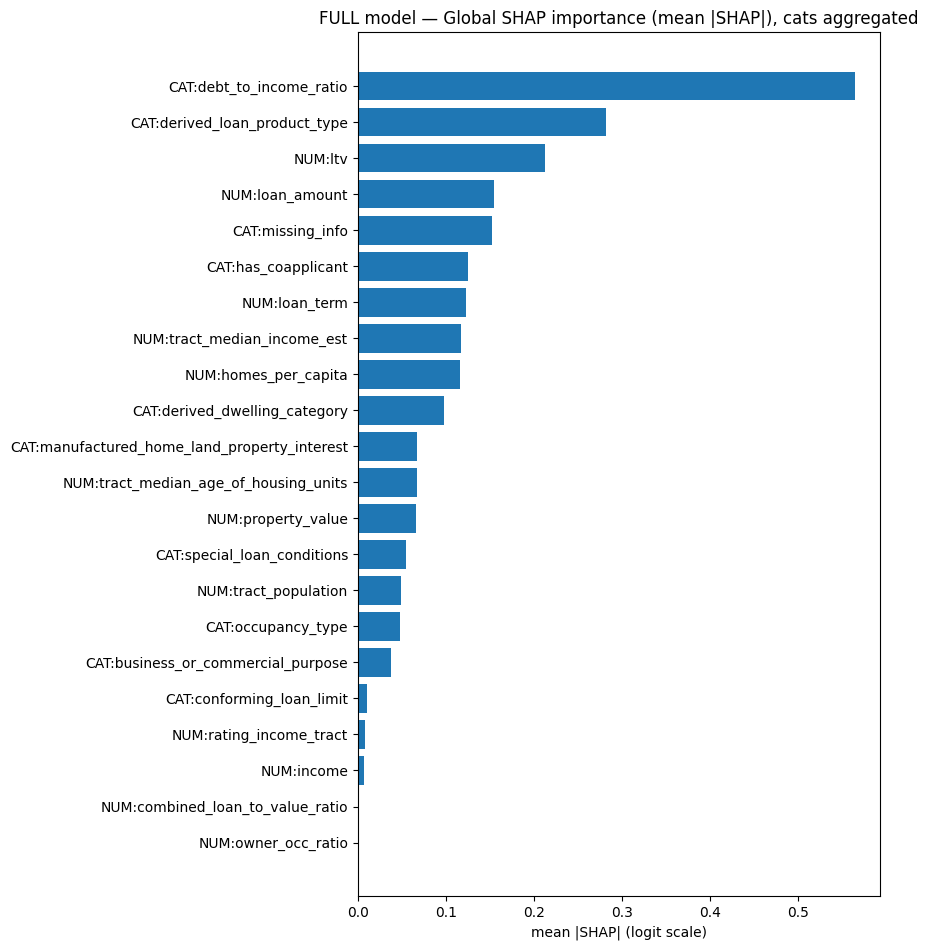

[INFO] SHAP summary (NUM only):


/tmp/ipython-input-2573704482.py:206: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_num, z_num, feature_names=num_cols_use, show=True)


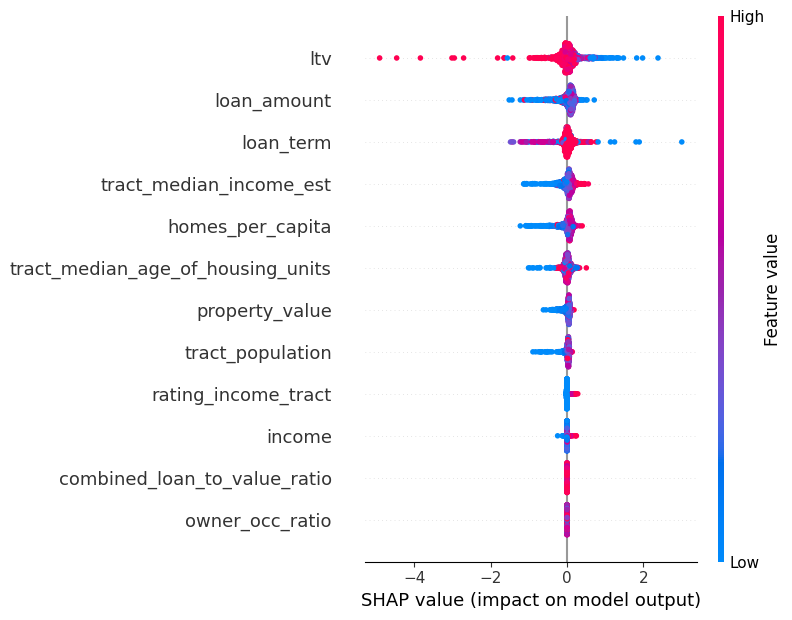

[INFO] In EXPL sample: FP=61, TN=72 (among y=0), thr=0.689620

[INFO] Top features with higher |SHAP| in FP than TN (push toward approve on negatives):


,feature,mean_abs_shap_FP,mean_abs_shap_TN,delta_FP_minus_TN
0,CAT:business_or_commercial_purpose,7.190720e-02,3.106593e-02,4.084127e-02
1,CAT:special_loan_conditions,6.582781e-02,5.389236e-02,1.193546e-02
2,CAT:conforming_loan_limit,1.045201e-02,4.564380e-03,5.887632e-03
3,NUM:income,1.451295e-02,1.110414e-02,3.408810e-03
4,NUM:owner_occ_ratio,9.585566e-10,4.396496e-09,-3.437940e-09
5,NUM:combined_loan_to_value_ratio,9.113514e-07,1.821649e-06,-9.102973e-07
6,CAT:has_coapplicant,1.055356e-01,1.223356e-01,-1.679994e-02
7,CAT:occupancy_type,4.556032e-02,6.362354e-02,-1.806322e-02
8,NUM:rating_income_tract,8.053061e-03,4.964067e-02,-4.158761e-02
9,NUM:loan_amount,2.052966e-01,2.815347e-01,-7.623814e-02


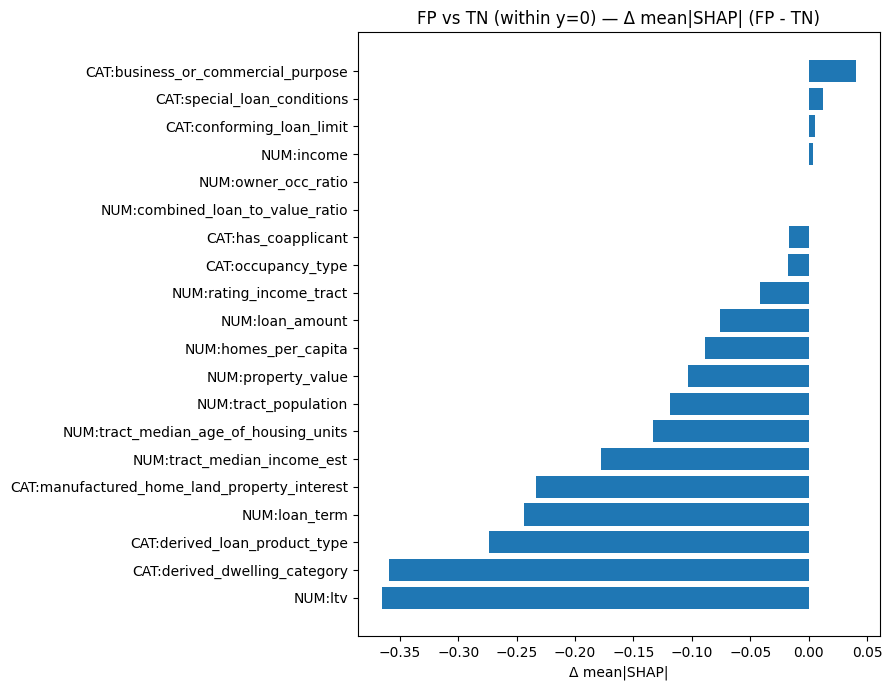

In [25]:
# =========================
# SHAP — FULL model (1 cell, end-to-end)
# Works for TabularNet (embeddings + numeric) wrapped by Lightning (HMDALitFull / HMDALitModule).
# Produces:
#  - Global importance (cats aggregated by embedding dims + nums)
#  - SHAP summary plot for numeric features
#  - (Optional) FP vs TN: what features differ in SHAP attributions among y=0
# =========================
# -------------------------
# 0) Resolve model + loader
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# pick Lightning module
lit = None
if "best_full" in globals():
    lit = best_full
else:
    raise KeyError("Не нашёл модель в памяти best_full.")

lit.eval().to(device)

# underlying TabularNet
net = getattr(lit, "model", None)
if net is None:
    raise AttributeError("У Lightning-модуля нет атрибута .model (ожидался TabularNet внутри).")

net.eval().to(device)

# pick loader (val preferred)
loader = None
if "val_loader_full" in globals():
    loader = val_loader_full
elif "test_loader_full" in globals():
    loader = test_loader_full
else:
    raise KeyError("Не нашёл DataLoader (val_loader_full/test_loader_full).")

# feature names (must exist)
if "cat_cols_full" in globals() and "num_cols_full" in globals():
    cat_cols = list(cat_cols_full)
    num_cols = list(num_cols_full)
else:
    raise KeyError("Не нашёл списки признаков cat_cols_full/num_cols_full.")

# threshold for FP/TN split (optional)
thr = 0.5
if hasattr(lit, "thr_buf"):
    try:
        thr = float(lit.thr_buf.detach().cpu().item())
    except Exception:
        thr = 0.5
elif "thr_full" in globals():
    thr = float(thr_full)

print(f"[INFO] SHAP target model = {type(lit).__name__}, device={device}, thr={thr:.6f}")
print(f"[INFO] n_cat={len(cat_cols)}  n_num={len(num_cols)}")

# -------------------------
# 1) Collect background + explain batches
# -------------------------
BG_N = 512
EXPL_N = 1024

@torch.no_grad()
def collect_for_shap(loader, max_rows, device):
    xs_cat, xs_num, ys = [], [], []
    n = 0
    for batch in loader:
        x_cat = batch["x_cat"]
        x_num = batch["x_num"]
        y = batch["y"].view(-1)

        take = min(x_cat.shape[0], max_rows - n)
        if take <= 0:
            break

        xs_cat.append(x_cat[:take].to(device))
        xs_num.append(x_num[:take].to(device))
        ys.append(y[:take].detach().cpu().numpy().astype(int))

        n += take
        if n >= max_rows:
            break

    return torch.cat(xs_cat, dim=0), torch.cat(xs_num, dim=0), np.concatenate(ys, axis=0)

xcat_bg, xnum_bg, y_bg = collect_for_shap(loader, BG_N, device)
xcat_ex, xnum_ex, y_ex = collect_for_shap(loader, EXPL_N, device)

print(f"[INFO] collected: bg={tuple(xcat_bg.shape)}+{tuple(xnum_bg.shape)}, ex={tuple(xcat_ex.shape)}+{tuple(xnum_ex.shape)}")

# -------------------------
# 2) Build z = [emb(cat)||x_num] and a z-only model (MLP+head)
# -------------------------
def build_z(tabnet, x_cat, x_num):
    embs = []
    for i, emb in enumerate(tabnet.emb_layers):
        embs.append(emb(x_cat[:, i]))
    x_emb = torch.cat(embs, dim=1) if len(embs) else torch.zeros((x_cat.shape[0], 0), device=x_cat.device)
    # IMPORTANT: do NOT apply emb_dropout here (keep deterministic)
    z = torch.cat([x_emb, x_num.float()], dim=1)
    return z

class ZOnlyModel(torch.nn.Module):
    """Accepts z and returns logits shaped [B,1] (needed by GradientExplainer)."""
    def __init__(self, tabnet):
        super().__init__()
        self.mlp = tabnet.mlp
        self.head = tabnet.head
    def forward(self, z):
        h = self.mlp(z)
        out = self.head(h)      # [B,1]
        return out

z_model = ZOnlyModel(net).to(device).eval()

with torch.no_grad():
    z_bg = build_z(net, xcat_bg, xnum_bg).float()
    z_ex = build_z(net, xcat_ex, xnum_ex).float()

# sanity
if not torch.isfinite(z_bg).all() or not torch.isfinite(z_ex).all():
    raise RuntimeError("Non-finite values in z (NaN/Inf). Проверь NumScaler/features.")
z_dim = int(z_bg.shape[1])
print(f"[INFO] z_dim={z_dim}")

# -------------------------
# 3) Run SHAP GradientExplainer on z
# -------------------------
def _safe_shap_array(shap_vals):
    # shap may return list or [N,D,1]
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]
    shap_vals = np.asarray(shap_vals)
    if shap_vals.ndim == 3 and shap_vals.shape[-1] == 1:
        shap_vals = shap_vals[..., 0]
    return shap_vals

# Note: nsamples controls approximation cost (smaller=faster)
explainer = shap.GradientExplainer(z_model, z_bg)
shap_vals = explainer.shap_values(z_ex, nsamples=200)
shap_vals = _safe_shap_array(shap_vals)  # [N,z_dim]

assert shap_vals.ndim == 2 and shap_vals.shape[1] == z_dim, f"Bad shap_vals shape: {shap_vals.shape}"
print(f"[INFO] shap_vals shape = {shap_vals.shape}")

# -------------------------
# 4) Aggregate SHAP to feature level
# -------------------------
emb_dims = [int(emb.weight.shape[1]) for emb in net.emb_layers]
emb_total = int(sum(emb_dims))
num_total = int(z_dim - emb_total)

if len(emb_dims) != len(cat_cols):
    print("[WARN] len(cat_cols) != #emb_layers. Using min alignment.")
    m = min(len(cat_cols), len(emb_dims))
    cat_cols_use = cat_cols[:m]
    emb_dims_use = emb_dims[:m]
else:
    cat_cols_use = cat_cols
    emb_dims_use = emb_dims

if num_total != len(num_cols):
    print(f"[WARN] num dim mismatch: z_num={num_total} vs num_cols={len(num_cols)}. "
          f"Will align by min().")
    num_cols_use = num_cols[:min(num_total, len(num_cols))]
    num_total_use = len(num_cols_use)
else:
    num_cols_use = num_cols
    num_total_use = num_total

mean_abs = np.mean(np.abs(shap_vals), axis=0)  # [z_dim]

rows = []
# CAT aggregated
start = 0
for col, d in zip(cat_cols_use, emb_dims_use):
    rows.append({"feature": f"CAT:{col}", "mean_abs_shap": float(mean_abs[start:start+d].sum())})
    start += d

# NUM per feature
for j, col in enumerate(num_cols_use):
    rows.append({"feature": f"NUM:{col}", "mean_abs_shap": float(mean_abs[emb_total + j])})

imp = pd.DataFrame(rows).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
display(imp.head(40))

# -------------------------
# 5) Plots: global importance + numeric SHAP summary
# -------------------------
TOPN = 30
plt.figure(figsize=(9, max(6, 0.32*TOPN)))
plt.barh(imp.loc[:TOPN-1, "feature"][::-1], imp.loc[:TOPN-1, "mean_abs_shap"][::-1])
plt.title("FULL model — Global SHAP importance (mean |SHAP|), cats aggregated")
plt.xlabel("mean |SHAP| (logit scale)")
plt.tight_layout()
plt.show()

# numeric-only summary plot
z_ex_np = z_ex.detach().cpu().numpy()
shap_num = shap_vals[:, emb_total:emb_total+num_total_use]
z_num = z_ex_np[:, emb_total:emb_total+num_total_use]

print("[INFO] SHAP summary (NUM only):")
shap.summary_plot(shap_num, z_num, feature_names=num_cols_use, show=True)

# -------------------------
# 6) (Optional) FP vs TN inside explain sample (y=0)
# -------------------------
with torch.no_grad():
    # compute probs for EXPL sample using full net (same as model does)
    logits_ex = lit(xcat_ex, xnum_ex).view(-1).float().clamp(-20.0, 20.0)
    p_ex = torch.sigmoid(logits_ex).detach().cpu().numpy()

pred_ex = (p_ex >= thr).astype(int)
mask_fp = (y_ex == 0) & (pred_ex == 1)
mask_tn = (y_ex == 0) & (pred_ex == 0)

fp_n = int(mask_fp.sum())
tn_n = int(mask_tn.sum())
print(f"[INFO] In EXPL sample: FP={fp_n}, TN={tn_n} (among y=0), thr={thr:.6f}")

if fp_n >= 10 and tn_n >= 10:
    # compare mean |SHAP| by feature (same aggregation)
    shap_abs = np.abs(shap_vals)

    # aggregate to rows[] order again
    def agg_mean_abs(mask):
        mabs = shap_abs[mask].mean(axis=0)  # [z_dim]
        out = []
        st = 0
        for col, d in zip(cat_cols_use, emb_dims_use):
            out.append(("CAT:"+col, float(mabs[st:st+d].sum())))
            st += d
        for j, col in enumerate(num_cols_use):
            out.append(("NUM:"+col, float(mabs[emb_total + j])))
        return pd.DataFrame(out, columns=["feature","mean_abs_shap"])

    fp_imp = agg_mean_abs(mask_fp)
    tn_imp = agg_mean_abs(mask_tn)
    diff = fp_imp.merge(tn_imp, on="feature", suffixes=("_FP","_TN"))
    diff["delta_FP_minus_TN"] = diff["mean_abs_shap_FP"] - diff["mean_abs_shap_TN"]
    diff = diff.sort_values("delta_FP_minus_TN", ascending=False).reset_index(drop=True)

    print("\n[INFO] Top features with higher |SHAP| in FP than TN (push toward approve on negatives):")
    display(diff.head(25))

    plt.figure(figsize=(9, 7))
    topk = diff.head(20)
    plt.barh(topk["feature"][::-1], topk["delta_FP_minus_TN"][::-1])
    plt.title("FP vs TN (within y=0) — Δ mean|SHAP| (FP - TN)")
    plt.xlabel("Δ mean|SHAP|")
    plt.tight_layout()
    plt.show()
else:
    print("[INFO] Too few FP/TN in EXPL sample to do FP-vs-TN SHAP diff. Increase EXPL_N if needed.")
